# **A3: Predicting Car Price**
## Dechathon Niamsa-ard st126235
Github Link: https://github.com/dniamsaard4codework/A3-Predicting-Car-Price.git

Link to the website: https://st126235.ml.brain.cs.ait.ac.th/a3-predict 


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pickle

# Check MLflow version
print(mlflow.__version__)

/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251
/Users/dechathonniamsa-ard/Documents/Dechathon_N/AIT/Machine Learning/A3 - Predicting Car Price/A3-Predicting-Car-Price/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


2.8.1


## Objective of the assignment
- Convert car price prediction into classification problem using Logistic Regression.
- Implement evaluation metrics (Accuracy, Precision, Recall, F1, Macro, Weighted) from scratch.
- Extend Logistic Regression to include Ridge (L2) regularization.
- Log experiments on the MLflow server.
- Deploy the best model using MLflow Model Registry.
- Set up CI/CD pipeline with GitHub Actions and unit testing.

## Task 1: Classification

In this task, I need to use the preprocessed dataset from A1/A2, and convert `selling_price` into 4 classes (0-3). After that, I need to implement the classification report from scratch, compare with the sklearn's classification report, and answer what support means in the report.

### Load dataset

In [2]:
# Load the dataset
df = pd.read_csv('../data/Cars.csv')

# Display the first few rows of the dataframe
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [4]:
# Display statistical summary of the dataset
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


### Apply preprocessed from A1/A2 to the dataset

In [5]:
# Perform some data cleaning for better analysis and visualization
# Parse from numeric columns and handle empty strings
df.mileage = pd.to_numeric(df.mileage.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.engine = pd.to_numeric(df.engine.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')
df.max_power = pd.to_numeric(df.max_power.str.split(' ', expand=True)[0].replace('', np.nan), errors='coerce')

# Rename the columns for better understanding
df = df.rename(columns={'name':'brand'})

# Drop the torque column
df = df.drop(columns=['torque'], errors='ignore')

# Remove all rows with CNG and LPG fuel types
df = df[~df['fuel'].isin(['CNG', 'LPG'])]

# Take the first word of name and remove the rest for brand class
df.brand = df.brand.str.split(' ', expand=True)[0]

# map feature owner to be First owner to 1, ..., Test Drive Car to 5
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}
df.owner = df.owner.map(owner_mapping).astype(int)

# Check the dataframe info
df.info()

# Remove the 'Test Drive Car' samples due not to involve in the training
df = df[df['owner'] != 5]

# Create a class that look like the pipeline but using with custom model classes (Same as A2)

# Manual Preprocessor class for data preprocessing
class ManualPreprocessor:
    def __init__(self, num_med_cols, num_mean_cols, cat_cols, drop_first=True):
        self.num_med_cols = list(num_med_cols)
        self.num_mean_cols = list(num_mean_cols)
        self.cat_cols = list(cat_cols)
        self.drop_first = drop_first
        # learned params
        self.medians_ = {}
        self.means_ = {}
        self.num_mean_for_scale_ = {}
        self.num_std_for_scale_ = {}
        self.cat_categories_ = {}
        self.feature_names_ = None
        self.is_fitted_ = False

    # Fit the preprocessor to the data
    def fit(self, X: pd.DataFrame):
        X = X.copy()

        # 1) impute stats
        for c in self.num_med_cols:
            if c in X.columns:
                self.medians_[c] = X[c].median()
        for c in self.num_mean_cols:
            if c in X.columns:
                self.means_[c] = X[c].mean()

        # 2) impute to compute scaler on train
        for c in self.num_med_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns:
                X[c] = X[c].fillna(self.means_[c])

        # 3) scaler stats (column-wise)
        num_all = self.num_med_cols + self.num_mean_cols
        for c in num_all:
            if c in X.columns:
                self.num_mean_for_scale_[c] = X[c].mean()
                self.num_std_for_scale_[c] = X[c].std(ddof=0)
                # Ensure std is not zero
                if self.num_std_for_scale_[c] == 0:
                    self.num_std_for_scale_[c] = 1.0

        # 4) categorical categories (store train cats; unknowns will be ignored)
        for c in self.cat_cols:
            if c in X.columns:
                cats = pd.Index(pd.Series(X[c], dtype="object").dropna().unique())
                # Use a deterministic order:
                self.cat_categories_[c] = pd.Index(sorted(cats.astype(str)))

        # 5) build feature names (without bias)
        self._build_feature_names()
        self.is_fitted_ = True
        return self

    # Helper method to build feature names
    def _build_feature_names(self):
        """Helper method to build feature names"""
        num_names = self.num_med_cols + self.num_mean_cols
        cat_names = []
        for c in self.cat_cols:
            if c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # drop_first=True -> drop the first category
                cats_keep = cats[1:] if self.drop_first and len(cats) > 0 else cats
                cat_names += [f"{c}={val}" for val in cats_keep] 
        self.feature_names_ = np.array(num_names + cat_names, dtype=object)

    # Transform the data using the fitted preprocessor
    def transform(self, X: pd.DataFrame) -> np.ndarray:
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before transform")
        
        X = X.copy()

        # 1) impute using train stats
        for c in self.num_med_cols:
            if c in X.columns and c in self.medians_:
                X[c] = X[c].fillna(self.medians_[c])
        for c in self.num_mean_cols:
            if c in X.columns and c in self.means_:
                X[c] = X[c].fillna(self.means_[c])

        # 2) scale numeric
        num_all = self.num_med_cols + self.num_mean_cols
        X_num = []
        for c in num_all:
            if c in X.columns and c in self.num_mean_for_scale_:
                mu = self.num_mean_for_scale_[c]
                sd = self.num_std_for_scale_[c]
                X_num.append(((X[c].astype(float) - mu) / sd).to_numpy())
        X_num = np.column_stack(X_num) if X_num else np.empty((len(X), 0))

        # 3) one-hot categorical using TRAIN categories
        X_cat_parts = []
        for c in self.cat_cols:
            if c in X.columns and c in self.cat_categories_:
                cats = self.cat_categories_[c]
                # force to training categories (unknown -> NaN -> all zeros after dummies)
                col = pd.Categorical(X[c].astype("object"), categories=cats)
                dummies = pd.get_dummies(col, prefix=c, prefix_sep='=', dummy_na=False) # get dummies
                # drop first category to avoid collinearity
                if self.drop_first and dummies.shape[1] > 0:
                    dummies = dummies.iloc[:, 1:]  # drop first category
                X_cat_parts.append(dummies.to_numpy(dtype=float))
        X_cat = np.column_stack(X_cat_parts) if X_cat_parts else np.empty((len(X), 0))

        # 4) concat numeric + categorical
        X_all = np.column_stack([X_num, X_cat]) if X_num.size > 0 or X_cat.size > 0 else np.empty((len(X), 0))

        # 5) add bias as first column
        bias = np.ones((X_all.shape[0], 1), dtype=float)
        X_with_bias = np.hstack([bias, X_all])
        return X_with_bias

    # Fit and transform the data
    def fit_transform(self, X: pd.DataFrame) -> np.ndarray:
        return self.fit(X).transform(X)

    # Get feature names after fitting
    def get_feature_names(self, include_bias=False):
        if not self.is_fitted_:
            raise ValueError("Preprocessor must be fitted before getting feature names")
        if include_bias:
            return np.array(["bias"] + list(self.feature_names_), dtype=object)  # Include bias term
        return self.feature_names_.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          8033 non-null   object 
 1   year           8033 non-null   int64  
 2   selling_price  8033 non-null   int64  
 3   km_driven      8033 non-null   int64  
 4   fuel           8033 non-null   object 
 5   seller_type    8033 non-null   object 
 6   transmission   8033 non-null   object 
 7   owner          8033 non-null   int64  
 8   mileage        7819 non-null   float64
 9   engine         7819 non-null   float64
 10  max_power      7825 non-null   float64
 11  seats          7819 non-null   float64
dtypes: float64(4), int64(4), object(4)
memory usage: 815.9+ KB


In [6]:
# Check the range of the selling_price column
print(f"Range of selling_price: {df['selling_price'].min()} to {df['selling_price'].max()}")
# Check the quartiles of the selling_price column
print(df['selling_price'].quantile([0.25, 0.5, 0.75]))

Range of selling_price: 29999 to 10000000
0.25    260000.0
0.50    450000.0
0.75    680000.0
Name: selling_price, dtype: float64


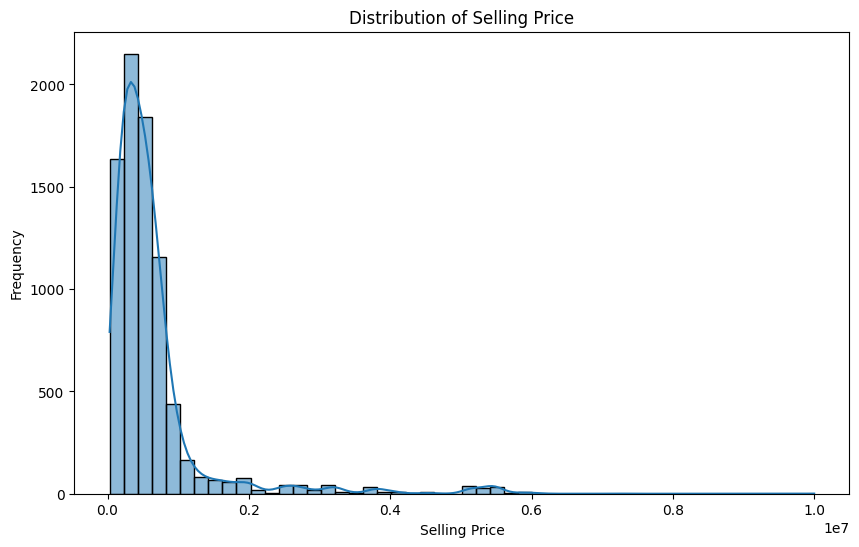

In [7]:
# Display the distribution of the selling_price column
plt.figure(figsize=(10, 6))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

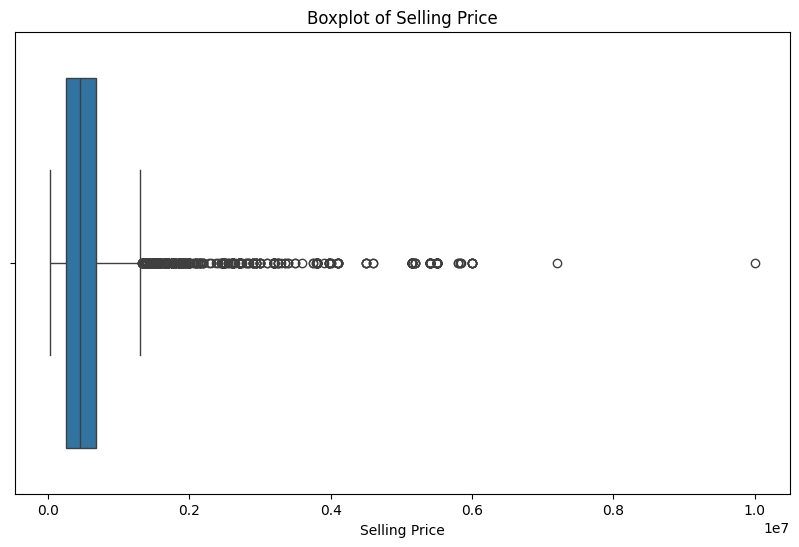

In [8]:
# Show boxplot to identify outliers in selling_price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['selling_price'])
plt.title('Boxplot of Selling Price')
plt.xlabel('Selling Price')
plt.show()

In [9]:
# Separate with pd.cut with quantiles
quantiles = df['selling_price'].quantile([0,0.25,0.5,0.75,1]).values
df['price_class'] = pd.cut(
    df['selling_price'],
    bins=quantiles,
    labels=[0,1,2,3],
    include_lowest=True
)
df.price_class.value_counts().sort_index() # check the distribution of price_class

price_class
0    2050
1    2044
2    1943
3    1991
Name: count, dtype: int64

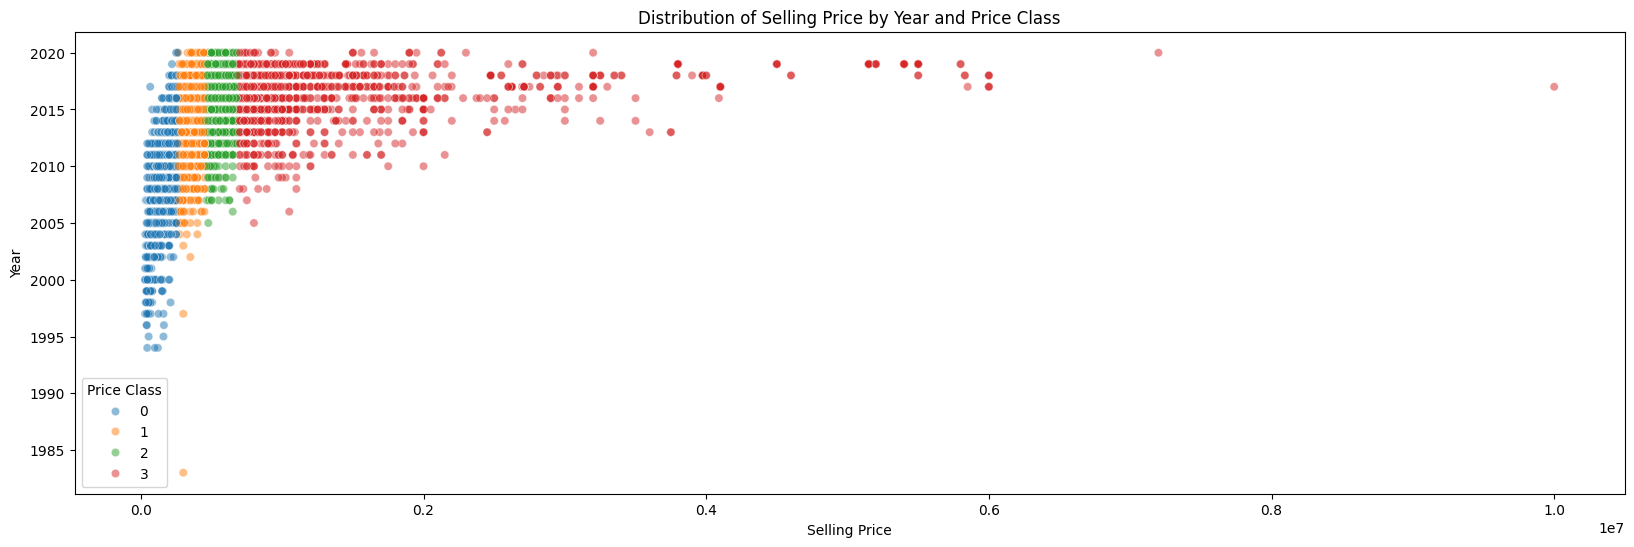

In [10]:
# Plot of selling_price with year and price_class
plt.figure(figsize=(20, 6))
sns.scatterplot(x='selling_price', y='year', hue='price_class', data=df, alpha=0.5)
plt.title('Distribution of Selling Price by Year and Price Class')
plt.xlabel('Selling Price')
plt.ylabel('Year')
plt.legend(title='Price Class')
plt.show()

In [11]:
# Display the first few rows of the dataframe
df.head()

,brand,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,price_class
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,5.0,1
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,5.0,1
2,Honda,2006,158000,140000,Petrol,Individual,Manual,3,17.70,1497.0,78.00,5.0,0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,5.0,0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,5.0,0


In [12]:
# Convert 'price_class' to categorical type
df['price_class'] = df['price_class'].astype('category')
# Show the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   brand          8028 non-null   object  
 1   year           8028 non-null   int64   
 2   selling_price  8028 non-null   int64   
 3   km_driven      8028 non-null   int64   
 4   fuel           8028 non-null   object  
 5   seller_type    8028 non-null   object  
 6   transmission   8028 non-null   object  
 7   owner          8028 non-null   int64   
 8   mileage        7814 non-null   float64 
 9   engine         7814 non-null   float64 
 10  max_power      7820 non-null   float64 
 11  seats          7814 non-null   float64 
 12  price_class    8028 non-null   category
dtypes: category(1), float64(4), int64(4), object(4)
memory usage: 823.4+ KB


In [13]:
# Select relevant features for the model
features = ['year', 'km_driven', 'fuel', 'transmission', 'owner',
            'engine', 'max_power', 'brand', 'mileage']
target = 'price_class'
print(features)

['year', 'km_driven', 'fuel', 'transmission', 'owner', 'engine', 'max_power', 'brand', 'mileage']


In [14]:
from sklearn.model_selection import train_test_split

# Split training set and testing set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
# Create feature sets for numerical and categorical features
features_num = [ft for ft in features if train_set[ft].dtype in [np.float64, np.int64]]
features_cat = [ft for ft in features if train_set[ft].dtype == 'object']

print("Numerical features:", features_num)
print("Categorical features:", features_cat)

Numerical features: ['year', 'km_driven', 'owner', 'engine', 'max_power', 'mileage']
Categorical features: ['fuel', 'transmission', 'brand']


In [16]:
# Split the data into features and target label
X_train = train_set[features].copy()
X_test = test_set[features].copy()
y_train = train_set[target].copy()
y_test = test_set[target].copy()

In [17]:
# Check the shapes of the datasets
print("The shape of training data is:", X_train.shape) # check the shape of training data
print("The shape of test data is:", X_test.shape) # check the shape of test data
print("The shape of training label is:", y_train.shape) # check the shape of training label
print("The shape of test label is:", y_test.shape) # check the shape of test label

The shape of training data is: (6422, 9)
The shape of test data is: (1606, 9)
The shape of training label is: (6422,)
The shape of test label is: (1606,)


In [18]:
# Define numerical columns for median and mean imputation
num_med_cols = [c for c in features_num if c != 'mileage']
num_mean_cols = ['mileage']

# Define categorical columns
cat_cols = features_cat

prep = ManualPreprocessor(num_med_cols, num_mean_cols, cat_cols, drop_first=True) # Apply to the code for ManualPreprocessor
X_train_transformed = prep.fit_transform(X_train) # Fit and transform the training data
X_test_transformed = prep.transform(X_test) # Transform the test data

# Display the shape of transformed data
print("X_train_transformed shape:", X_train_transformed.shape)
print("X_test_transformed shape:", X_test_transformed.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

# Display the type of transformed data
print("Type of X_train_transformed:", type(X_train_transformed))
print("Type of X_test_transformed:", type(X_test_transformed))
print("Type of y_train:", type(y_train))
print("Type of y_test:", type(y_test))

X_train_transformed shape: (6422, 38)
X_test_transformed shape: (1606, 38)
y train shape: (6422,)
y test shape: (1606,)
Type of X_train_transformed: <class 'numpy.ndarray'>
Type of X_test_transformed: <class 'numpy.ndarray'>
Type of y_train: <class 'pandas.core.series.Series'>
Type of y_test: <class 'pandas.core.series.Series'>


In [19]:
# Create one-hot encoded arrays for training
def to_one_hot(y, num_classes):
    """Convert numeric labels to one-hot encoding"""
    y = y.cat.codes  # Convert categorical to numeric codes
    one_hot = np.zeros((len(y), num_classes))
    one_hot[np.arange(len(y)), y] = 1
    return one_hot

# Convert to one-hot for the model for 4 classes
y_train_one_hot = to_one_hot(y_train, 4)

# Display the shape of one-hot encoded labels
print("Original y_train shape:", y_train.shape)
print("One-hot y_train shape:", y_train_one_hot.shape)

# Verify the conversion
print("\nFirst few y_train values:", y_train.head().values)
print("First few y_train:", y_train[:5])
print("First few y_train_one_hot:")
print(y_train_one_hot[:5])

Original y_train shape: (6422,)
One-hot y_train shape: (6422, 4)

First few y_train values: [0, 0, 0, 3, 0]
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train: 2982    0
2430    0
6294    0
6255    3
4253    0
Name: price_class, dtype: category
Categories (4, int64): [0 < 1 < 2 < 3]
First few y_train_one_hot:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### Modify LogisticRegression() class from `02 - Multinomial Logistic Regression.ipynb` 


In [20]:
class LogisticRegression(object):
    
    # Initialize the model with hyperparameters
    def __init__(self, regularization, k, n, method, alpha = 0.001, max_iter=5000):
        self.k = k # number of classes
        self.n = n # number of features
        self.alpha = alpha # learning rate
        self.max_iter = max_iter # maximum number of iterations
        self.method = method # optimization method
        self.regularization = regularization # regularization method
    
    # Fit the model to the training data
    def fit(self, X, Y):
        self.W = np.random.rand(self.n, self.k)
        self.losses = []
        
        # Choose optimization method
        if self.method == "batch": # batch gradient descent
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad =  self.gradient(X, Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        elif self.method == "minibatch": # mini-batch gradient descent
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                ix = np.random.randint(0, X.shape[0]) #<----with replacement sampling
                batch_X = X[ix:ix+batch_size]
                batch_Y = Y[ix:ix+batch_size]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")

        elif self.method == "sto": # stochastic gradient descent
            start_time = time.time()
            list_of_used_ix = []
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])
                while i in list_of_used_ix:
                    idx = np.random.randint(X.shape[0])
                X_train = X[idx, :].reshape(1, -1)
                Y_train = Y[idx]
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W = self.W - self.alpha * grad
                
                list_of_used_ix.append(i)
                if len(list_of_used_ix) == X.shape[0]:
                    list_of_used_ix = []
                if i % 500 == 0:
                    print(f"Loss at iteration {i}", loss)
            print(f"time taken: {time.time() - start_time}")
            
        else:
            raise ValueError('Method must be one of the followings: "batch", "minibatch" or "sto".')
        
    # Compute the gradient and loss    
    def gradient(self, X, Y):
        m = X.shape[0]
        h = self.h_theta(X, self.W)
        loss = - np.sum(Y*np.log(h)) / m  
        loss += self.regularization(self.W, m) # add regularization term to the loss
        error = h - Y
        grad = self.softmax_grad(X, error) 
        grad += self.regularization.derivative(self.W, m) # add regularization term to the gradient
        return loss, grad

    # Softmax function
    def softmax(self, theta_t_x):
        return np.exp(theta_t_x) / np.sum(np.exp(theta_t_x), axis=1, keepdims=True)

    # Gradient of the softmax function
    def softmax_grad(self, X, error):
        return  X.T @ error

    # Hypothesis function
    def h_theta(self, X, W):
        '''
        Input:
            X shape: (m, n)
            w shape: (n, k)
        Returns:
            yhat shape: (m, k)
        '''
        return self.softmax(X @ W)
    
    # Predict the class labels for the test data
    def predict(self, X_test):
        return np.argmax(self.h_theta(X_test, self.W), axis=1)
    
    # Plot the training losses over iterations
    def plot(self):
        plt.plot(np.arange(len(self.losses)) , self.losses, label = "Train Losses")
        plt.title("Losses")
        plt.xlabel("epoch")
        plt.ylabel("losses")
        plt.legend()

    # Evaluation metrics
    # Compute accuracy
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    # Compute precision for a specific class
    def precision(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FP = np.sum((y_true != cls) & (y_pred == cls))
        return TP / (TP + FP) if (TP + FP) > 0 else 0.0

    # Compute recall for a specific class
    def recall(self, y_true, y_pred, cls):
        TP = np.sum((y_true == cls) & (y_pred == cls))
        FN = np.sum((y_true == cls) & (y_pred != cls))
        return TP / (TP + FN) if (TP + FN) > 0 else 0.0

    # Compute F1-score for a specific class
    def f1_score(self, y_true, y_pred, cls):
        prec = self.precision(y_true, y_pred, cls)
        rec = self.recall(y_true, y_pred, cls)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

    # Macro and weighted averages
    # Compute macro precision
    def macro_precision(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.precision(y_true, y_pred, cls) for cls in classes])

    # Compute macro recall
    def macro_recall(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.recall(y_true, y_pred, cls) for cls in classes])

    # Compute macro F1-score
    def macro_f1_score(self, y_true, y_pred):
        classes = np.unique(y_true)
        return np.mean([self.f1_score(y_true, y_pred, cls) for cls in classes])

    # Compute weighted precision, recall, and F1-score
    def weighted_precision(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.precision(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Compute weighted recall
    def weighted_recall(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.recall(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Compute weighted F1-score
    def weighted_f1_score(self, y_true, y_pred):
        classes, counts = np.unique(y_true, return_counts=True)
        total = len(y_true)
        return np.sum([self.f1_score(y_true, y_pred, cls) * (count / total) for cls, count in zip(classes, counts)])

    # Generate a classification report similar to sklearn's classification_report
    def classification_report(self, y_true, y_pred, digits=2):
        classes, counts = np.unique(y_true, return_counts=True)
        total_support = np.sum(counts)

        report = {}

        # Per-class metrics
        for cls, count in zip(classes, counts):
            cls_str = str(cls)
            p = self.precision(y_true, y_pred, cls)
            r = self.recall(y_true, y_pred, cls)
            f = self.f1_score(y_true, y_pred, cls)
            report[cls_str] = {
                "precision": round(p, digits),
                "recall": round(r, digits),
                "f1-score": round(f, digits),
                "support": int(count)
            }

        # Accuracy
        acc = self.accuracy(y_true, y_pred)
        report["accuracy"] = {
            "precision": "",
            "recall": "",
            "f1-score": round(acc, digits),
            "support": int(total_support)
        }

        # Macro avg
        macro_p = self.macro_precision(y_true, y_pred)
        macro_r = self.macro_recall(y_true, y_pred)
        macro_f = self.macro_f1_score(y_true, y_pred)
        report["macro avg"] = {
            "precision": round(macro_p, digits),
            "recall": round(macro_r, digits),
            "f1-score": round(macro_f, digits),
            "support": int(total_support)
        }

        # Weighted avg
        weighted_p = self.weighted_precision(y_true, y_pred)
        weighted_r = self.weighted_recall(y_true, y_pred)
        weighted_f = self.weighted_f1_score(y_true, y_pred)
        report["weighted avg"] = {
            "precision": round(weighted_p, digits),
            "recall": round(weighted_r, digits),
            "f1-score": round(weighted_f, digits),
            "support": int(total_support)
        }

        return pd.DataFrame(report).T

    

## Task 2: Ridge Logistic Regression

- Add Ridge Logistic Regression
    $$J(\theta) = -\sum_{i=1}^m y^{(i)}\log(h^{(i)}) + \lambda\sum_{j=1}^n \theta_j^{2}$$

In [21]:
# Define Ridge regularization and No regularization classes
class RidgePenalty:
    def __init__(self, l2):
        self.l2 = l2 # regularization strength

    def __call__(self, theta, m):
        return (self.l2 / (2 * m)) * np.sum(np.square(theta)) # L2 regularization term for loss

    def derivative(self, theta, m):
        return (2 * self.l2 / m) * theta # Derivative of L2 regularization term for gradient

# Define No regularization class
class NoPenalty:
    def __call__(self, theta, m=None):
        return 0.0

    def derivative(self, theta, m=None):
        return np.zeros_like(theta)

# Define Ridge and Simple Logistic Regression classes from LogisticRegression
# Ridge regression with L2 regularization
class Ridge(LogisticRegression):
    def __init__(self, k, n, method, alpha, l2):
        self.regularization = RidgePenalty(l2)
        super().__init__(self.regularization, k, n, method, alpha)

# Simple logistic regression without regularization
class SimpleLogistic(LogisticRegression):
    def __init__(self, k, n, method, alpha):
        self.regularization = NoPenalty()
        super().__init__(self.regularization, k, n, method, alpha)

Loss at iteration 0 1.573849260563634
Loss at iteration 500 1.117553877816371
Loss at iteration 1000 1.0948111399040477
Loss at iteration 1500 1.0894669045646985
Loss at iteration 2000 1.0872202804426847
Loss at iteration 2500 1.0858585135969507
Loss at iteration 3000 1.0849031436978958
Loss at iteration 3500 1.0842023482170404
Loss at iteration 4000 1.083682881068546
Loss at iteration 4500 1.0832970572271312
time taken: 3.8169898986816406
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.93      0.62      0.74       411
           1       0.54      0.87      0.66       456
           2       0.53      0.11      0.19       352
           3       0.69      0.93      0.79       387

    accuracy                           0.65      1606
   macro avg       0.67      0.63      0.60      1606
weighted avg       0.67      0.65      0.61      1606

Report from custom model: 
              precision recall f1-score support

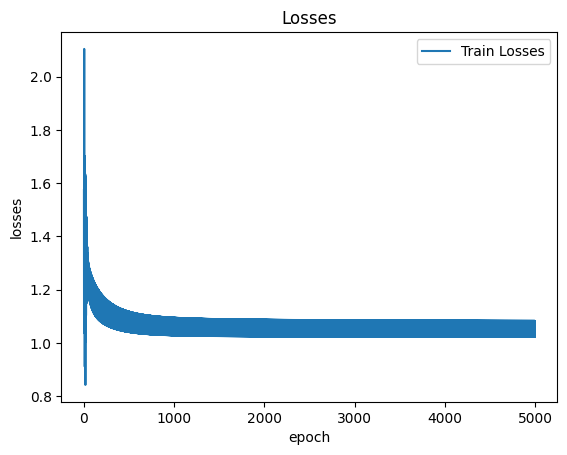

In [22]:
# Test the model and classification report with the car dataset for Ridge regression
# Train the model with properly formatted data
model = Ridge(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001, l2=0.1)
model.fit(X_train_transformed, y_train_one_hot)
yhat = model.predict(X_test_transformed)
model.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("Report from custom model: \n", model.classification_report(y_test, yhat))

Loss at iteration 0 1.5125126355267338
Loss at iteration 500 1.114110980591362
Loss at iteration 1000 1.090422922399488
Loss at iteration 1500 1.0847553735366788
Loss at iteration 2000 1.0823032129312198
Loss at iteration 2500 1.0807670184755187
Loss at iteration 3000 1.0796486555747526
Loss at iteration 3500 1.0787942411096303
Loss at iteration 4000 1.0781310447726087
Loss at iteration 4500 1.0776107944886253
time taken: 3.6502327919006348
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.93      0.62      0.74       411
           1       0.54      0.87      0.66       456
           2       0.53      0.11      0.19       352
           3       0.69      0.93      0.79       387

    accuracy                           0.65      1606
   macro avg       0.67      0.63      0.60      1606
weighted avg       0.67      0.65      0.61      1606

Report from custom model: 
              precision recall f1-score suppor

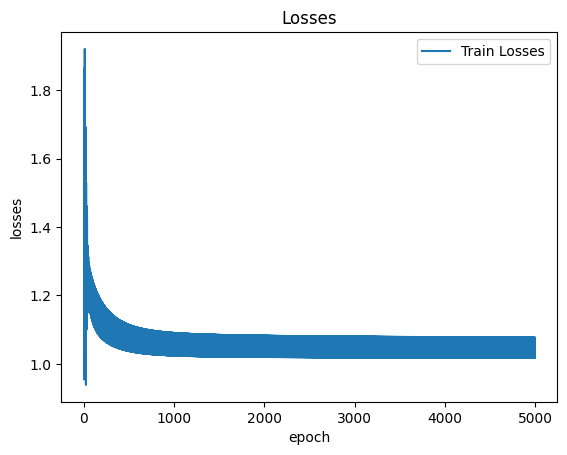

In [23]:
# Test the model and classification report with the car dataset for simple logistic regression
# Train the model with properly formatted data
model2 = SimpleLogistic(len(set(y_train)), X_train_transformed.shape[1], "batch", alpha=0.001)
model2.fit(X_train_transformed, y_train_one_hot)
yhat2 = model2.predict(X_test_transformed)
model2.plot()
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat2))
print("Report from custom model: \n", model2.classification_report(y_test, yhat2))

## Task 3: Deployment

- Log model to MLFlow
- Register model
- Set up model to staging
- CI/CD Deployment

### Set up MLFlow

In [24]:
# Set up MLflow tracking
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
mlflow.set_tracking_uri("https://mlflow.ml.brain.cs.ait.ac.th/")
os.environ["LOGNAME"] = "st126235"
mlflow.set_experiment("st126235-a3")

<Experiment: artifact_location='mlflow-artifacts:/607305997044080535', creation_time=1759391076743, experiment_id='607305997044080535', last_update_time=1759391076743, lifecycle_stage='active', name='st126235-a3', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [25]:
# Helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

===== Training SimpleLogistic with batch and learning rate 0.01 =====
Loss at iteration 0 1.4100684677825301


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_728/760719979.py:69: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_728/760719979.py:69: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
time taken: 3.8454928398132324


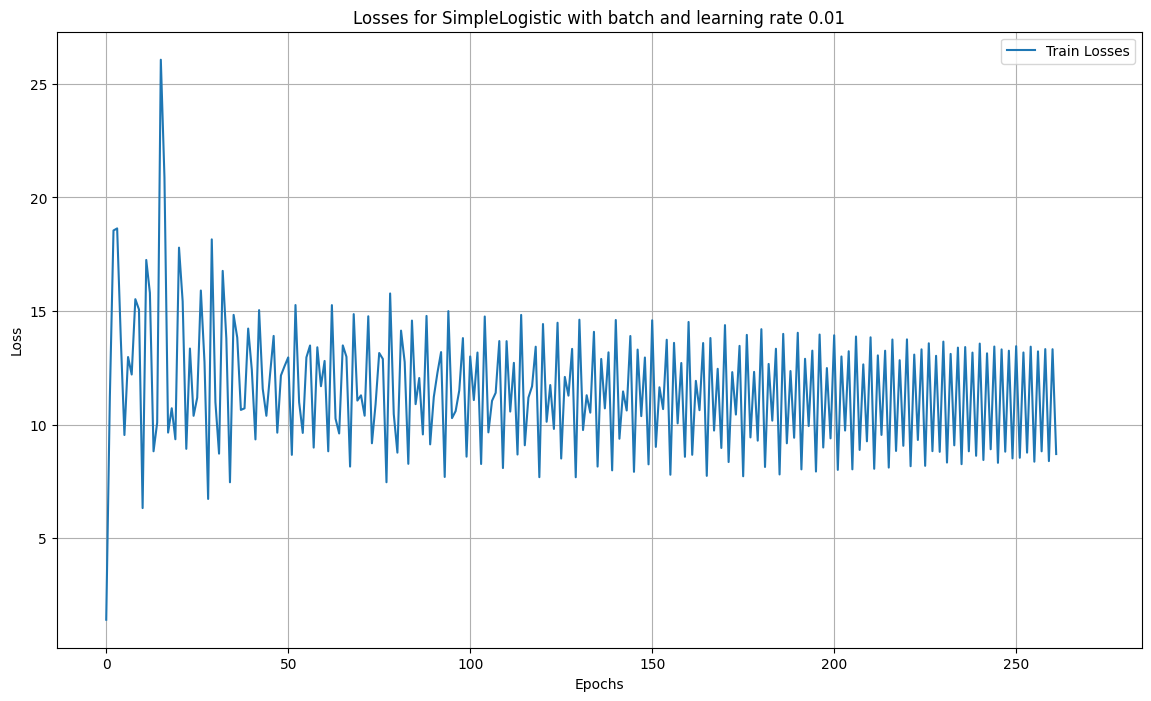

=========Classification report=======
             precision recall f1-score support
0                 0.94   0.56     0.71   411.0
1                 0.52   0.89     0.66   456.0
2                 0.52   0.07     0.13   352.0
3                 0.68   0.93     0.79   387.0
accuracy                          0.64    1606
macro avg         0.67   0.61     0.57  1606.0
weighted avg      0.67   0.64     0.58  1606.0
===== Training SimpleLogistic with batch and learning rate 0.001 =====
Loss at iteration 0 1.6955372673870546
Loss at iteration 500 1.0376923867113788
Loss at iteration 1000 1.0244712230338808
Loss at iteration 1500 1.0214515666365354
Loss at iteration 2000 1.0202350468852064
Loss at iteration 2500 1.0194863226908943
Loss at iteration 3000 1.018922932479353
Loss at iteration 3500 1.0184646192948226
Loss at iteration 4000 1.0180803132580662
Loss at iteration 4500 1.0177536974406796
time taken: 3.6417758464813232


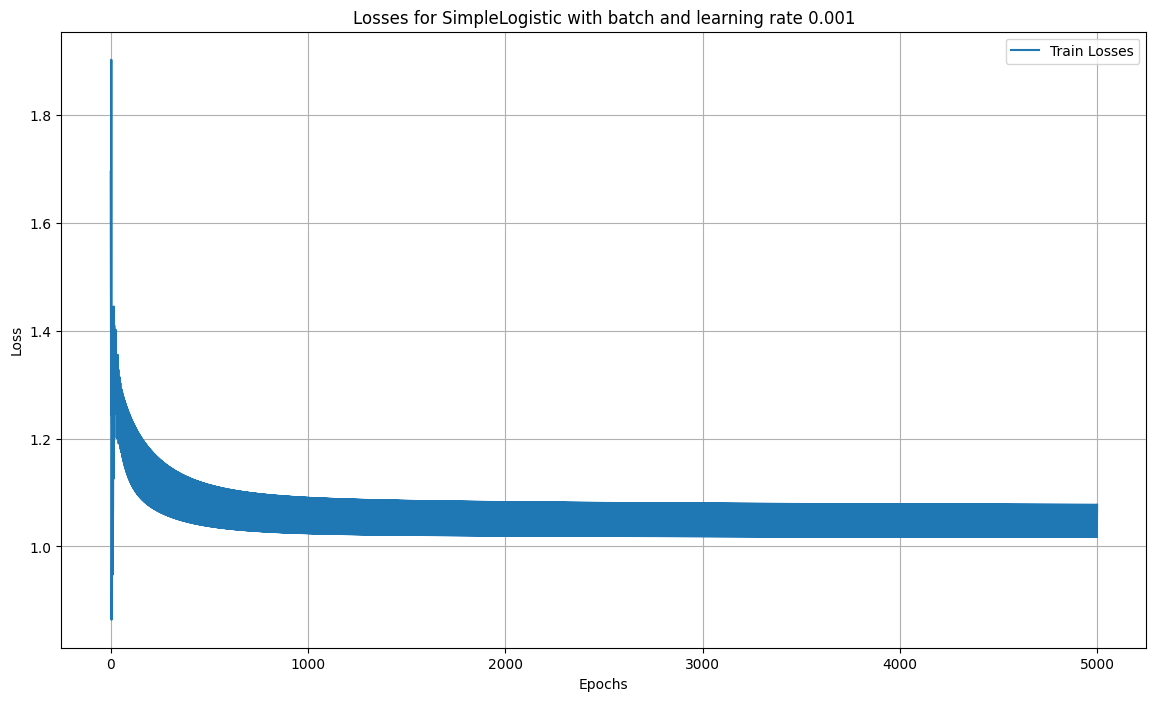

=========Classification report=======
             precision recall f1-score support
0                 0.71   0.95     0.81   411.0
1                  0.7   0.16     0.26   456.0
2                 0.46   0.89     0.61   352.0
3                 0.94   0.64     0.76   387.0
accuracy                          0.64    1606
macro avg          0.7   0.66     0.61  1606.0
weighted avg      0.71   0.64      0.6  1606.0
===== Training SimpleLogistic with batch and learning rate 0.0001 =====
Loss at iteration 0 1.9095420970622108
Loss at iteration 500 0.6083755244693075
Loss at iteration 1000 0.5917206784009087
Loss at iteration 1500 0.5858878844827391
Loss at iteration 2000 0.5831777586626595
Loss at iteration 2500 0.5817092064563867
Loss at iteration 3000 0.5808192370997111
Loss at iteration 3500 0.5802291601336336
Loss at iteration 4000 0.5798079564940818
Loss at iteration 4500 0.5794887689498002
time taken: 3.4832680225372314


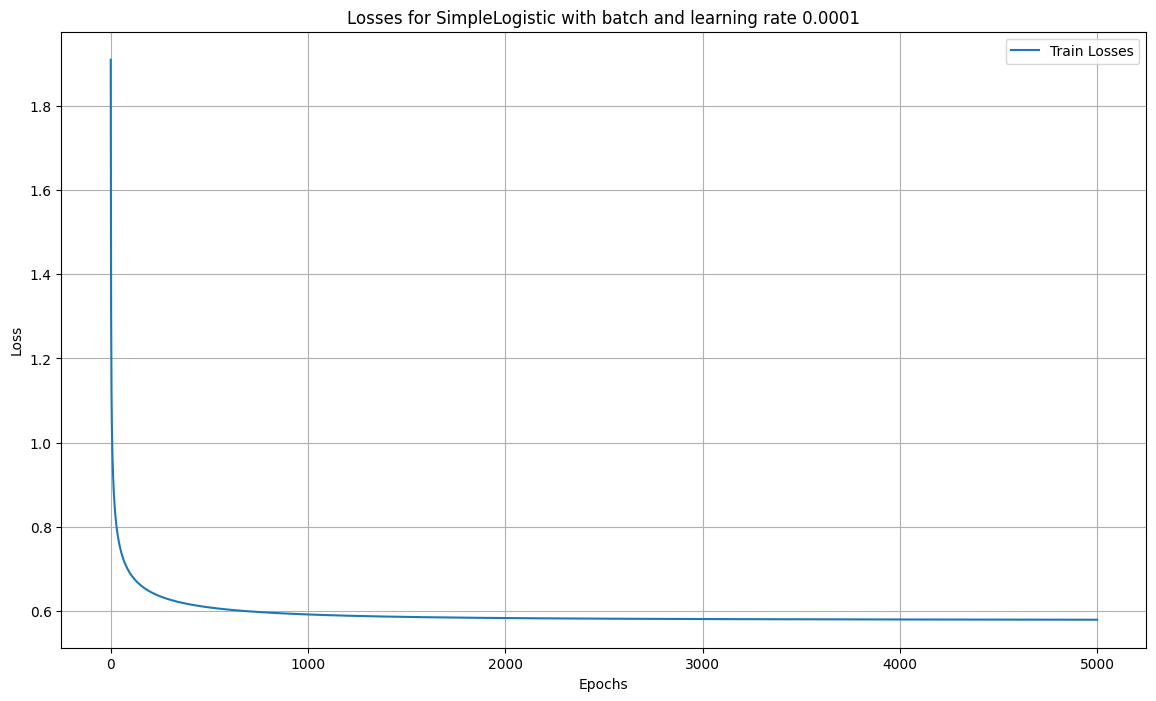

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.85     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.5596394105906046
Loss at iteration 500 2.8783459804845615
Loss at iteration 1000 1.1479371399129394
Loss at iteration 1500 2.7291240740127485
Loss at iteration 2000 1.1107067631817589
Loss at iteration 2500 2.541773143577706
Loss at iteration 3000 3.907917085126963
Loss at iteration 3500 2.3956804692311904
Loss at iteration 4000 3.610490049233246
Loss at iteration 4500 2.2653881157796856
time taken: 1.2930219173431396


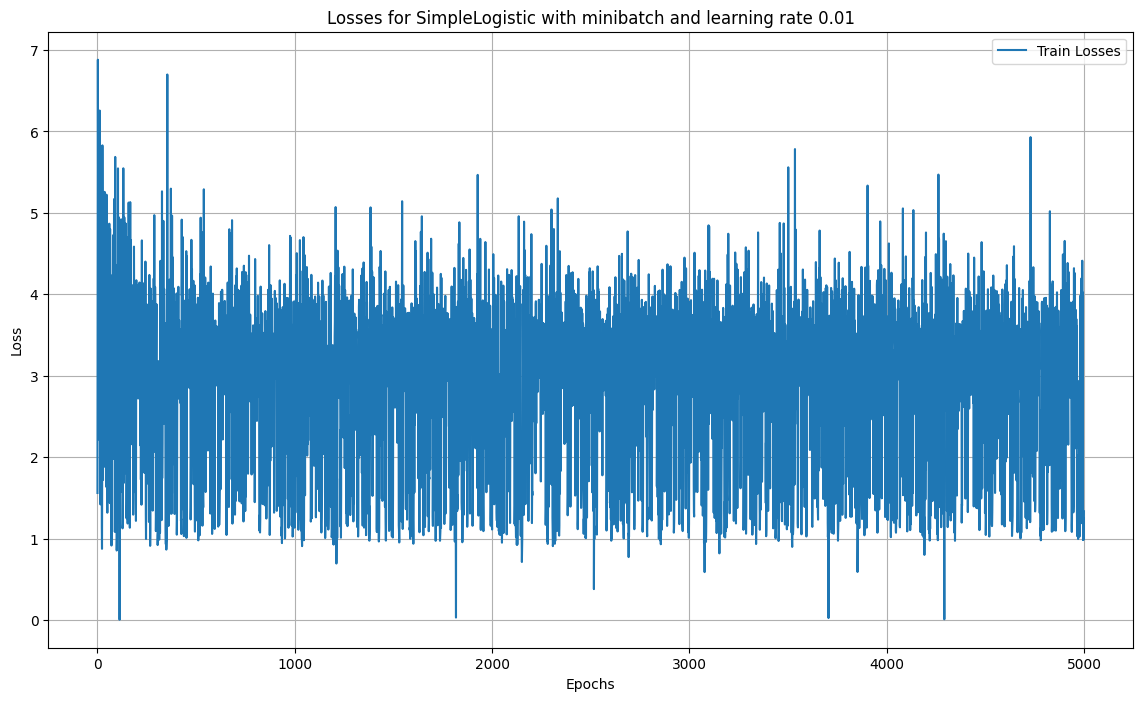

=========Classification report=======
             precision recall f1-score support
0                 0.84   0.86     0.85   411.0
1                  0.7   0.68     0.69   456.0
2                 0.63   0.62     0.63   352.0
3                 0.84   0.87     0.85   387.0
accuracy                          0.76    1606
macro avg         0.75   0.76     0.75  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.5783132966094338
Loss at iteration 500 0.5832905418634112
Loss at iteration 1000 0.5850721563914446
Loss at iteration 1500 0.5977185138054079
Loss at iteration 2000 0.5599029754775353
Loss at iteration 2500 0.561255690260988
Loss at iteration 3000 0.5862972931850139
Loss at iteration 3500 0.615225261528336
Loss at iteration 4000 0.6118693067013531
Loss at iteration 4500 0.5800310466431129
time taken: 1.1112580299377441


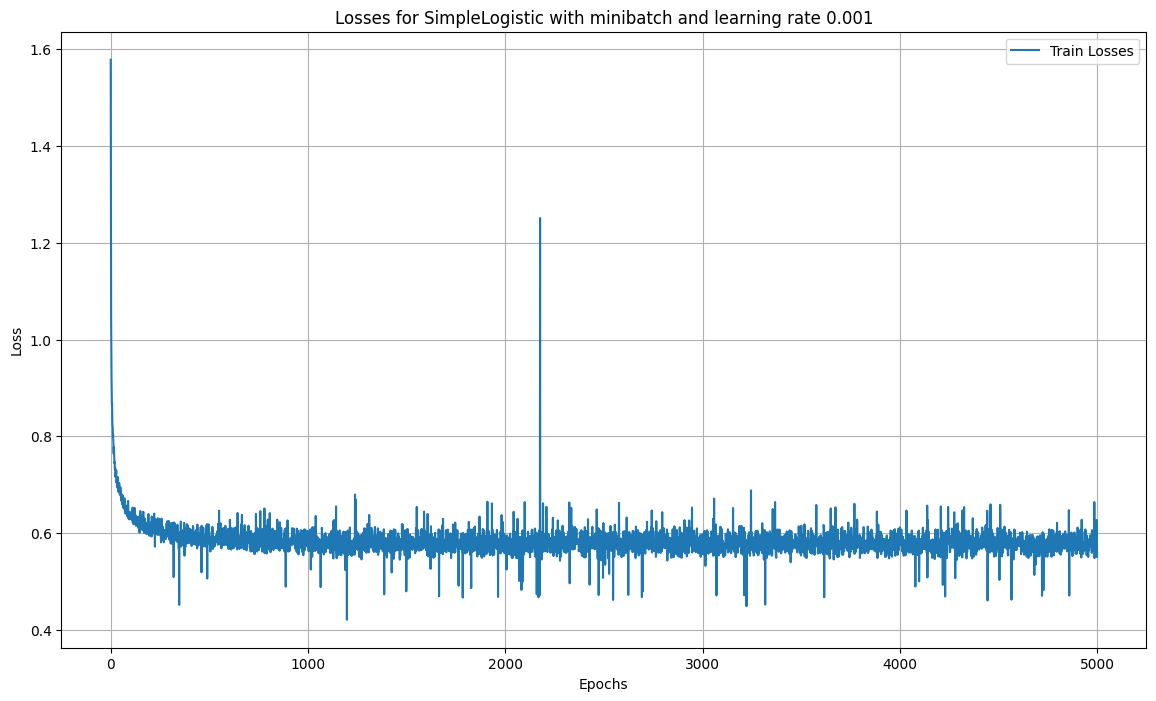

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                  0.7   0.68     0.69   456.0
2                 0.62   0.72     0.66   352.0
3                 0.88   0.82     0.85   387.0
accuracy                          0.76    1606
macro avg         0.77   0.76     0.76  1606.0
weighted avg      0.77   0.76     0.76  1606.0
===== Training SimpleLogistic with minibatch and learning rate 0.0001 =====
Loss at iteration 0 1.3833050704527314
Loss at iteration 500 0.6774530313298596
Loss at iteration 1000 0.6295677817385504
Loss at iteration 1500 0.6107793863085403
Loss at iteration 2000 0.6117691140983642
Loss at iteration 2500 0.5933475306456437
Loss at iteration 3000 0.6055962447123294
Loss at iteration 3500 0.5863811580091106
Loss at iteration 4000 0.5710114565100495
Loss at iteration 4500 0.580725287224247
time taken: 1.100954294204712


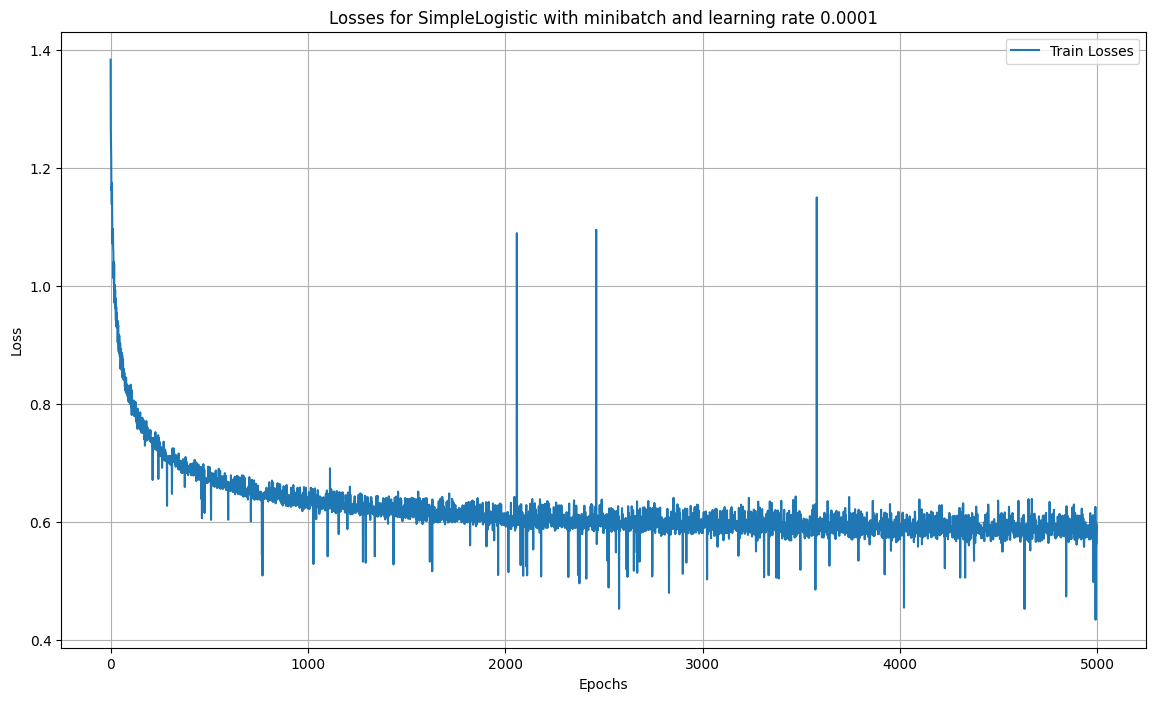

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.82     0.83   411.0
1                 0.69   0.68     0.69   456.0
2                 0.62   0.68     0.65   352.0
3                 0.86   0.84     0.85   387.0
accuracy                          0.75    1606
macro avg         0.76   0.75     0.75  1606.0
weighted avg      0.76   0.75     0.75  1606.0
===== Training SimpleLogistic with sto and learning rate 0.01 =====
Loss at iteration 0 0.9287659074107418
Loss at iteration 500 0.4338186868262415
Loss at iteration 1000 0.6285127904674482
Loss at iteration 1500 1.1702357719748606
Loss at iteration 2000 1.336693554781866
Loss at iteration 2500 1.6349193919228617
Loss at iteration 3000 0.9291580260253764
Loss at iteration 3500 0.49031501323604215
Loss at iteration 4000 0.14005584388039174
Loss at iteration 4500 0.8842745848783662
time taken: 0.1366431713104248


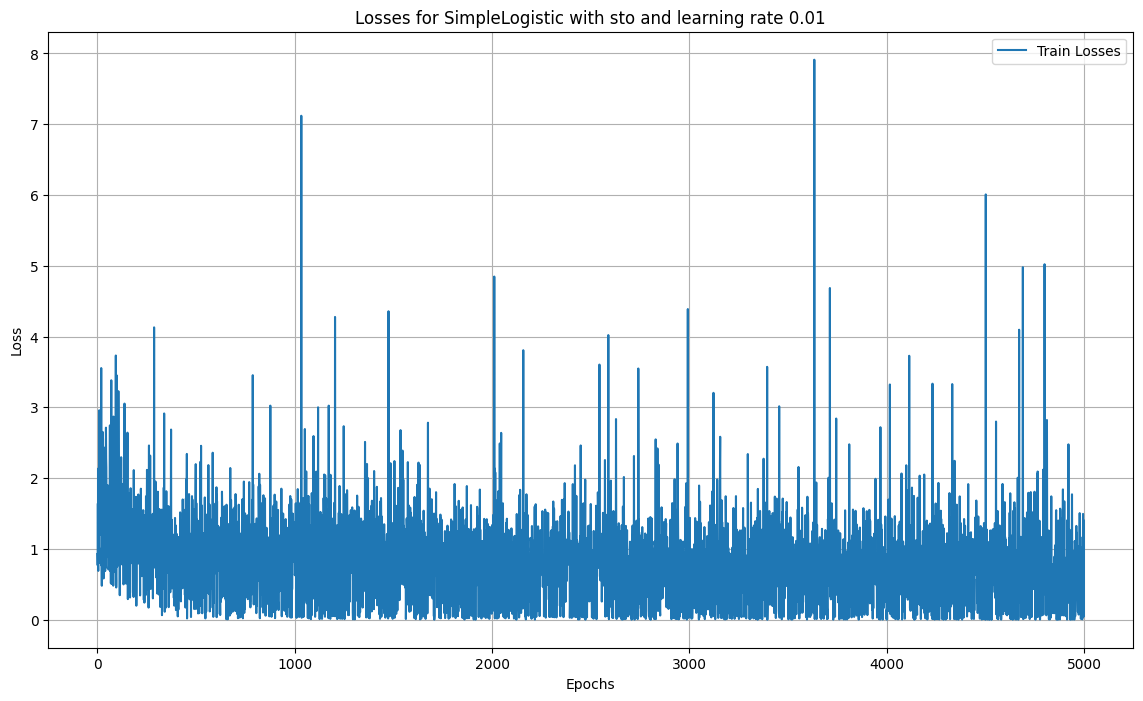

=========Classification report=======
             precision recall f1-score support
0                 0.81    0.8      0.8   411.0
1                 0.64   0.67     0.66   456.0
2                 0.57   0.53     0.55   352.0
3                 0.76   0.79     0.78   387.0
accuracy                           0.7    1606
macro avg          0.7    0.7      0.7  1606.0
weighted avg       0.7    0.7      0.7  1606.0
===== Training SimpleLogistic with sto and learning rate 0.001 =====
Loss at iteration 0 0.8544513491231195
Loss at iteration 500 3.010805365836799
Loss at iteration 1000 1.0949462343217735
Loss at iteration 1500 1.3590481413645603
Loss at iteration 2000 0.6088546928502321
Loss at iteration 2500 0.6674150119155846
Loss at iteration 3000 1.3361902051124421
Loss at iteration 3500 0.8896801225977893
Loss at iteration 4000 1.6558458660226527
Loss at iteration 4500 0.924361253451025
time taken: 0.15443825721740723


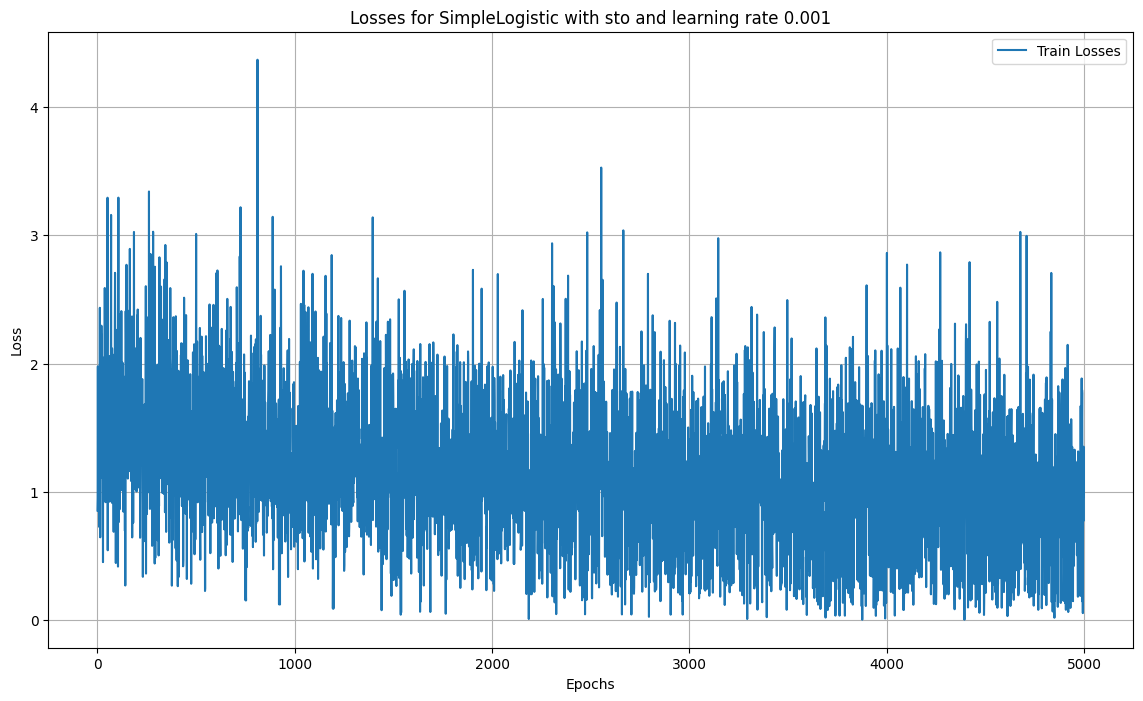

=========Classification report=======
             precision recall f1-score support
0                 0.63   0.82     0.71   411.0
1                 0.49   0.27     0.35   456.0
2                  0.4   0.45     0.42   352.0
3                 0.68   0.73     0.71   387.0
accuracy                          0.56    1606
macro avg         0.55   0.57     0.55  1606.0
weighted avg      0.55   0.56     0.55  1606.0
===== Training SimpleLogistic with sto and learning rate 0.0001 =====
Loss at iteration 0 3.80063241511897
Loss at iteration 500 1.017239052060982
Loss at iteration 1000 1.4229327329037234
Loss at iteration 1500 3.0153487019589975
Loss at iteration 2000 1.0253665607665985
Loss at iteration 2500 1.92179566623078
Loss at iteration 3000 1.6927236140420154
Loss at iteration 3500 1.0617706079346492
Loss at iteration 4000 2.3990917980928184
Loss at iteration 4500 0.5557763511823473
time taken: 0.15198111534118652


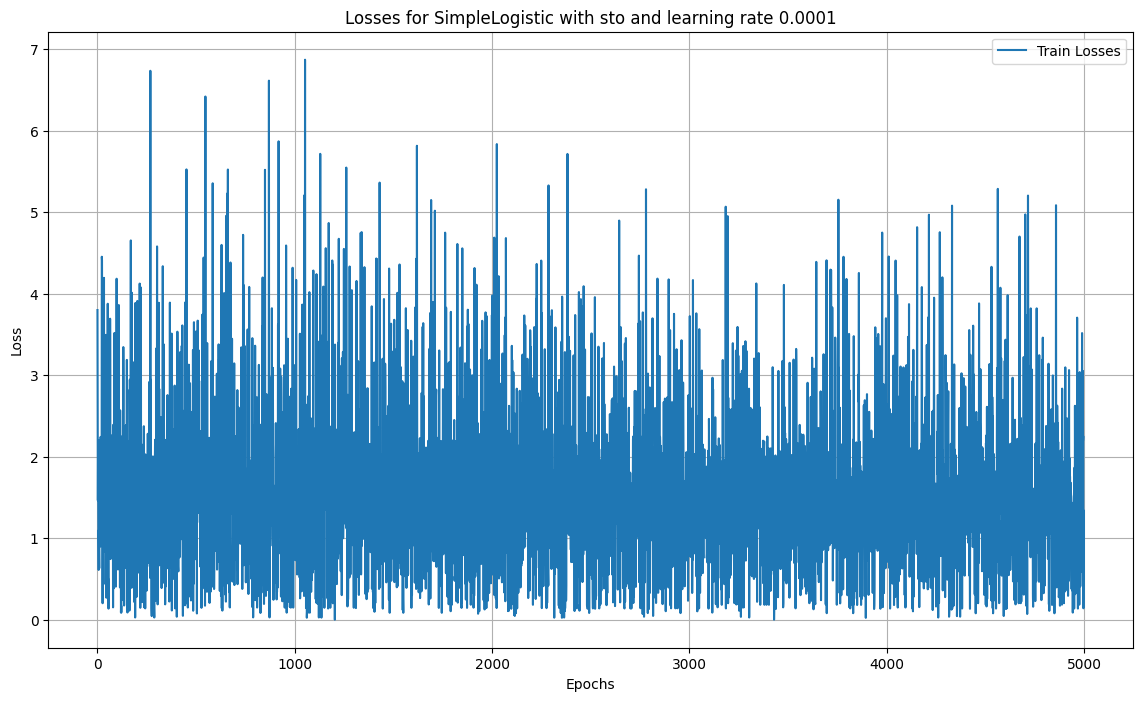

=========Classification report=======
             precision recall f1-score support
0                 0.25   0.08     0.12   411.0
1                 0.36   0.27      0.3   456.0
2                 0.11   0.17     0.13   352.0
3                 0.53   0.79     0.63   387.0
accuracy                          0.32    1606
macro avg         0.31   0.33      0.3  1606.0
weighted avg      0.32   0.32      0.3  1606.0
===== Training Ridge with batch and learning rate 0.01 =====
Loss at iteration 0 1.697389982802322


/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_728/760719979.py:69: RuntimeWarning: divide by zero encountered in log
  loss = - np.sum(Y*np.log(h)) / m
/var/folders/wr/4dhn7j5j6s7gsbn883b1ws9w0000gn/T/ipykernel_728/760719979.py:69: RuntimeWarning: invalid value encountered in multiply
  loss = - np.sum(Y*np.log(h)) / m


Loss at iteration 500 nan
Loss at iteration 1000 nan
Loss at iteration 1500 nan
Loss at iteration 2000 nan
Loss at iteration 2500 nan
Loss at iteration 3000 nan
Loss at iteration 3500 nan
Loss at iteration 4000 nan
Loss at iteration 4500 nan
time taken: 3.733647108078003


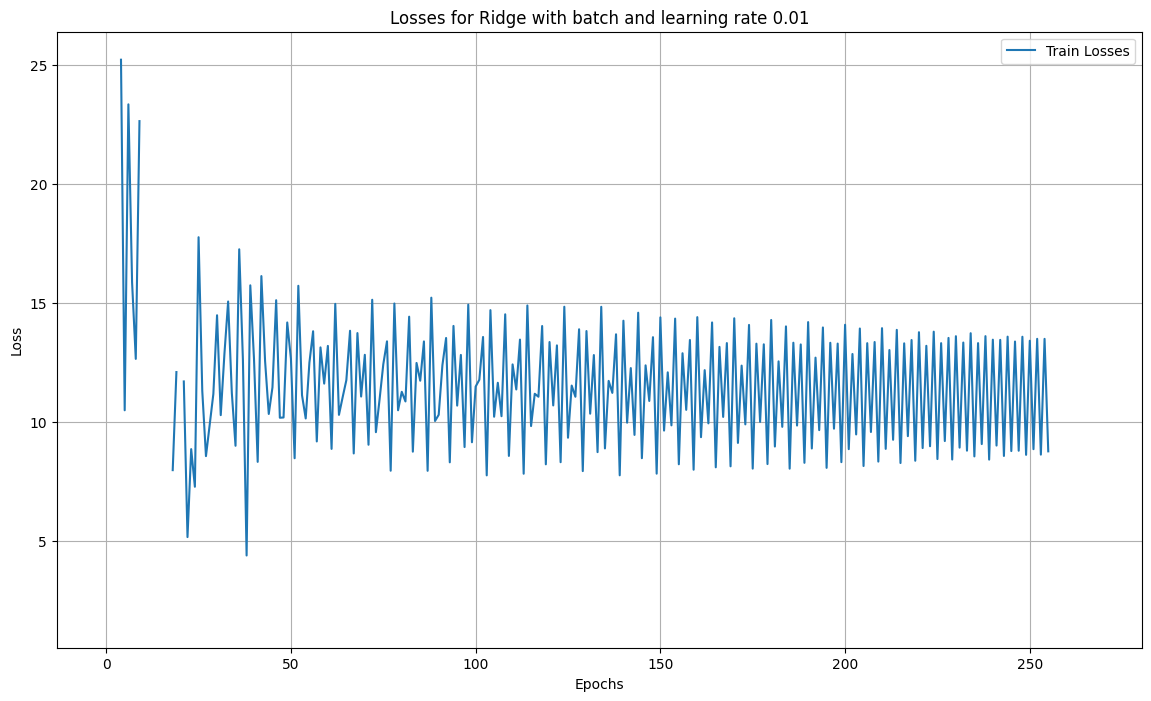

=========Classification report=======
             precision recall f1-score support
0                 0.94   0.56     0.71   411.0
1                 0.52   0.89     0.66   456.0
2                 0.51   0.07     0.12   352.0
3                 0.68   0.94     0.79   387.0
accuracy                          0.64    1606
macro avg         0.66   0.62     0.57  1606.0
weighted avg      0.67   0.64     0.59  1606.0
===== Training Ridge with batch and learning rate 0.001 =====
Loss at iteration 0 1.6522465236798225
Loss at iteration 500 1.04154119908964
Loss at iteration 1000 1.0289231439873132
Loss at iteration 1500 1.0261695962045423
Loss at iteration 2000 1.0251479378222077
Loss at iteration 2500 1.024571618214053
Loss at iteration 3000 1.02416731381337
Loss at iteration 3500 1.0238566698314355
Loss at iteration 4000 1.0236099750852852
Loss at iteration 4500 1.0234127067102976
time taken: 3.705875873565674


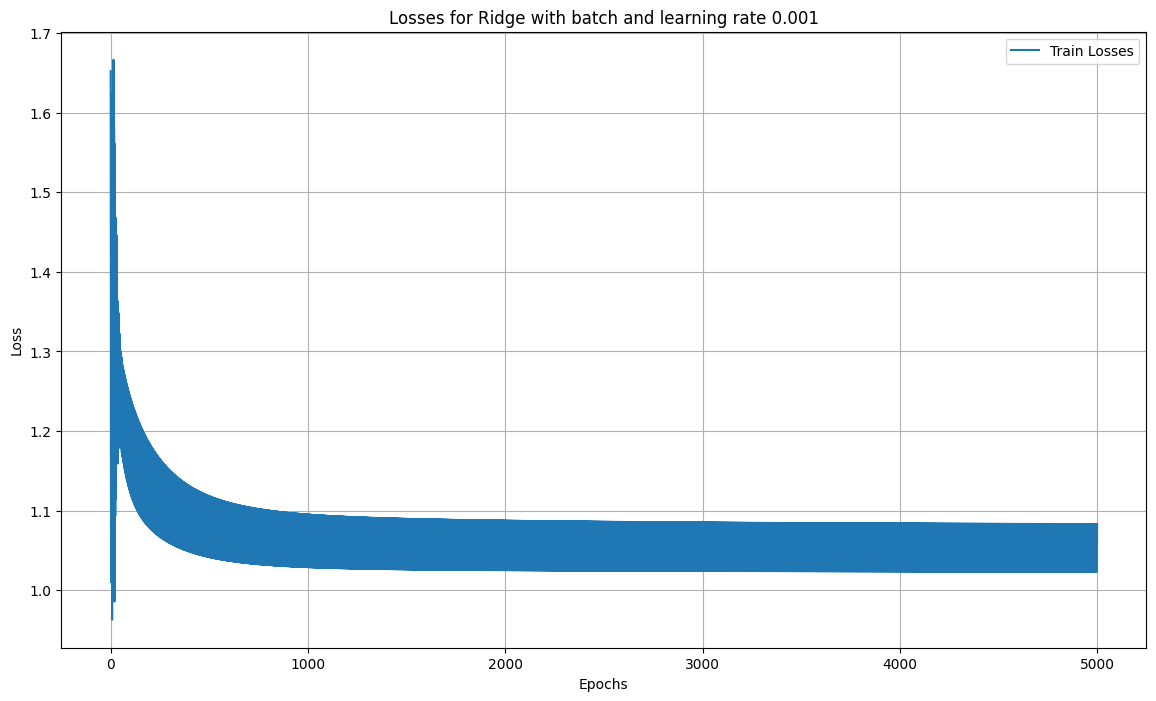

=========Classification report=======
             precision recall f1-score support
0                 0.71   0.95     0.81   411.0
1                  0.7   0.16     0.26   456.0
2                 0.46   0.89     0.61   352.0
3                 0.94   0.64     0.76   387.0
accuracy                          0.64    1606
macro avg          0.7   0.66     0.61  1606.0
weighted avg      0.71   0.64      0.6  1606.0
===== Training Ridge with batch and learning rate 0.0001 =====
Loss at iteration 0 1.9724079818573317
Loss at iteration 500 0.6107925726312503
Loss at iteration 1000 0.5933638997813202
Loss at iteration 1500 0.5873393839460874
Loss at iteration 2000 0.5846096174999856
Loss at iteration 2500 0.583172527933005
Loss at iteration 3000 0.5823275229771727
Loss at iteration 3500 0.5817835972839358
Loss at iteration 4000 0.5814058636580409
Loss at iteration 4500 0.5811265600302092
time taken: 3.4037790298461914


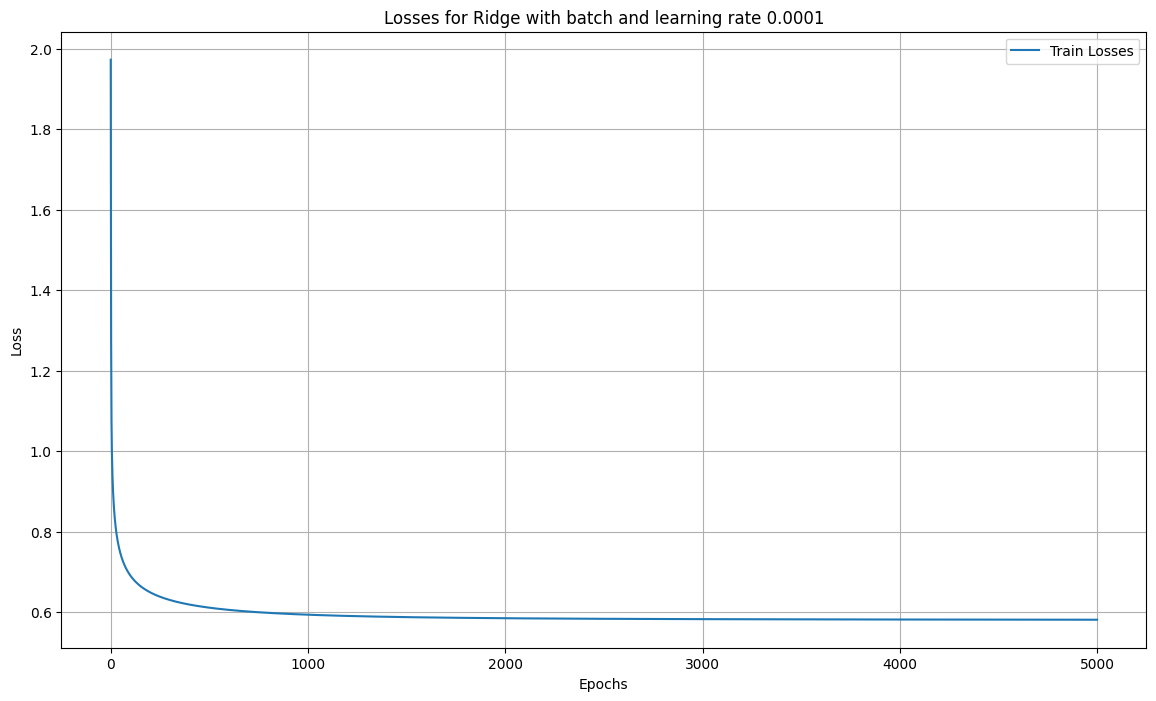

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.82     0.84   411.0
1                 0.69   0.68     0.69   456.0
2                 0.63   0.69     0.66   352.0
3                 0.87   0.85     0.86   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with minibatch and learning rate 0.01 =====
Loss at iteration 0 1.6646179848985578
Loss at iteration 500 2.69378046168685
Loss at iteration 1000 3.775329297447527
Loss at iteration 1500 2.7330255081989843
Loss at iteration 2000 1.356697740642975
Loss at iteration 2500 1.238642742218574
Loss at iteration 3000 3.511594731915961
Loss at iteration 3500 2.230368486263327
Loss at iteration 4000 1.805144625308914
Loss at iteration 4500 3.8047761395581006
time taken: 1.3051221370697021


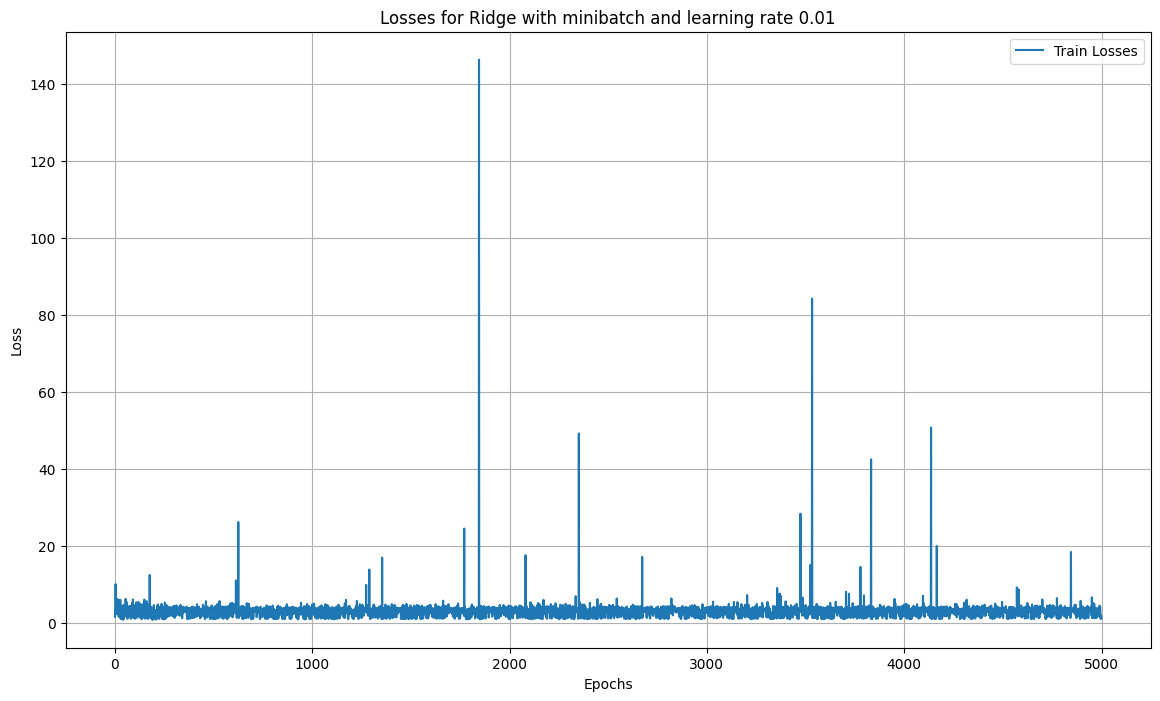

=========Classification report=======
             precision recall f1-score support
0                 0.74   0.93     0.82   411.0
1                 0.67   0.17     0.27   456.0
2                 0.42   0.86     0.56   352.0
3                 0.89   0.58      0.7   387.0
accuracy                          0.61    1606
macro avg         0.68   0.63     0.59  1606.0
weighted avg      0.68   0.61     0.58  1606.0
===== Training Ridge with minibatch and learning rate 0.001 =====
Loss at iteration 0 1.895708083491881
Loss at iteration 500 0.5964895537887596
Loss at iteration 1000 0.5658161122409195
Loss at iteration 1500 0.5621324009306267
Loss at iteration 2000 0.5893321216200486
Loss at iteration 2500 0.57406756090062
Loss at iteration 3000 0.7070332594556044
Loss at iteration 3500 0.5674836694779205
Loss at iteration 4000 0.6143866720511914
Loss at iteration 4500 0.573338178921532
time taken: 1.3251550197601318


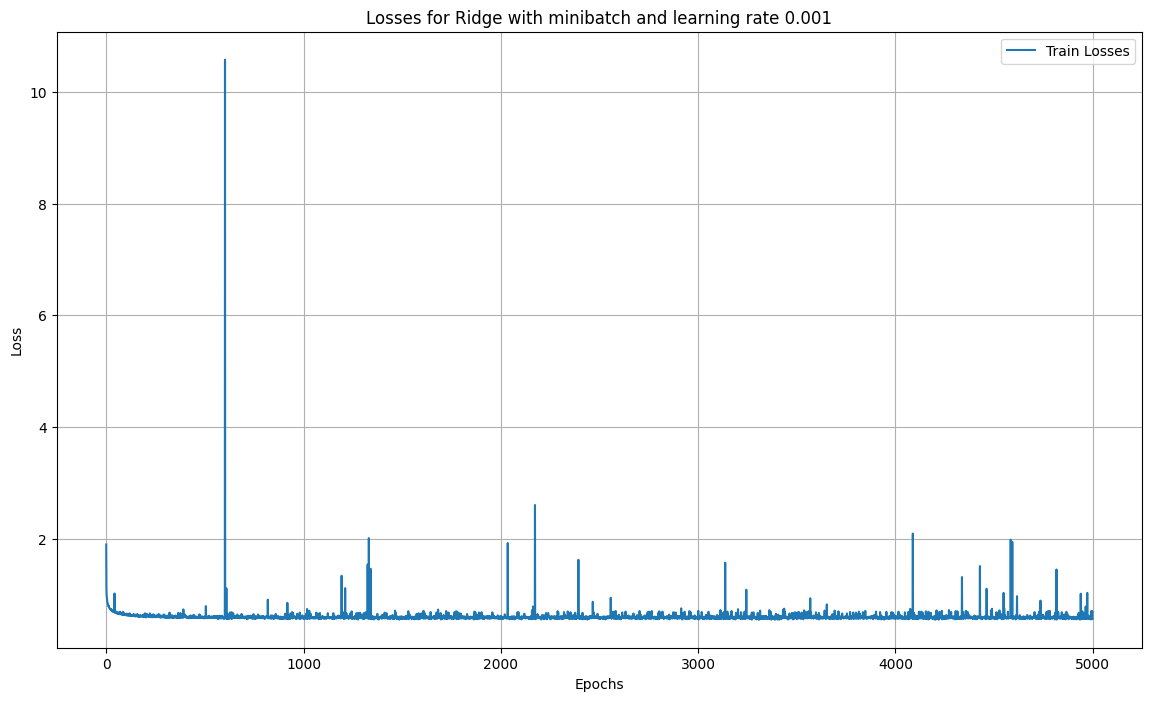

=========Classification report=======
             precision recall f1-score support
0                 0.86   0.84     0.85   411.0
1                 0.71   0.68     0.69   456.0
2                 0.62   0.71     0.67   352.0
3                 0.88   0.83     0.86   387.0
accuracy                          0.76    1606
macro avg         0.77   0.77     0.77  1606.0
weighted avg      0.77   0.76     0.77  1606.0
===== Training Ridge with minibatch and learning rate 0.0001 =====
Loss at iteration 0 1.6468132137193865
Loss at iteration 500 0.6875028691464529
Loss at iteration 1000 0.6197437478831883
Loss at iteration 1500 0.6288386440590475
Loss at iteration 2000 0.6174924218279528
Loss at iteration 2500 0.5937197310419974
Loss at iteration 3000 0.6043473353761539
Loss at iteration 3500 0.620468978645143
Loss at iteration 4000 0.607188811639286
Loss at iteration 4500 0.6176453700110243
time taken: 1.3146331310272217


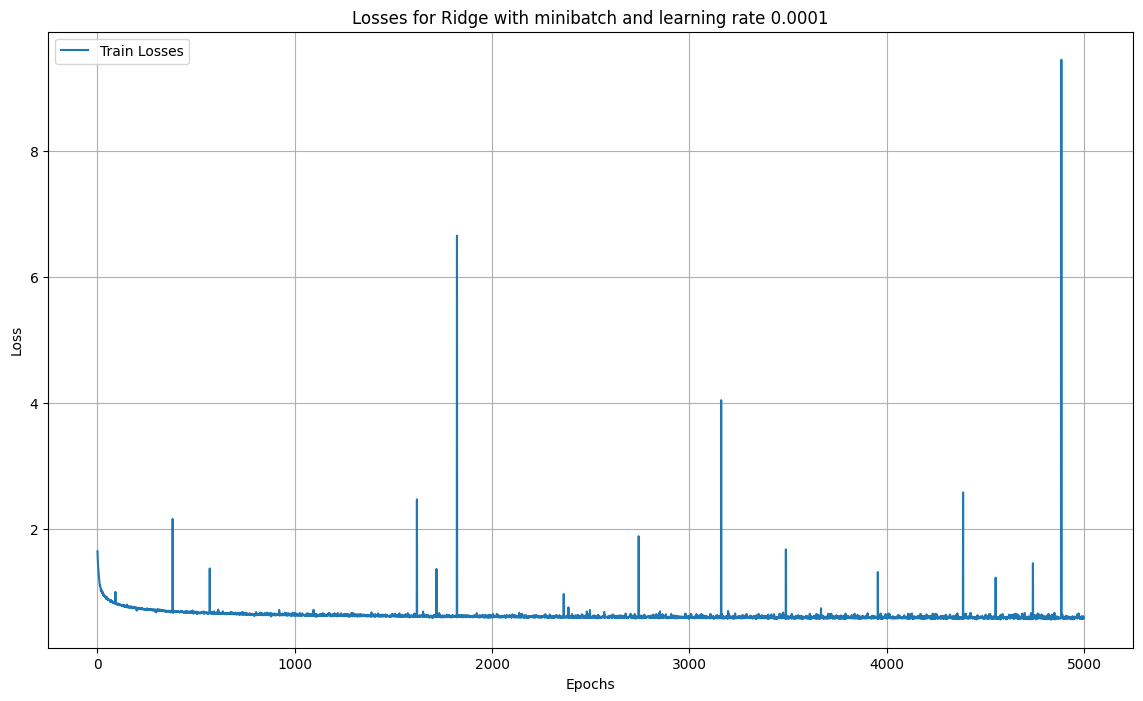

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.82     0.84   411.0
1                  0.7   0.69     0.69   456.0
2                 0.62   0.68     0.65   352.0
3                 0.87   0.84     0.85   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0
===== Training Ridge with sto and learning rate 0.01 =====
Loss at iteration 0 4.914275368053151
Loss at iteration 500 0.6528094362635383
Loss at iteration 1000 0.3818772241606561
Loss at iteration 1500 1.7533197506395368
Loss at iteration 2000 0.9277065950375626
Loss at iteration 2500 1.0010892838131566
Loss at iteration 3000 0.377128839851822
Loss at iteration 3500 1.1053713684229427
Loss at iteration 4000 0.3529913076244197
Loss at iteration 4500 0.8072599672762168
time taken: 0.1427309513092041


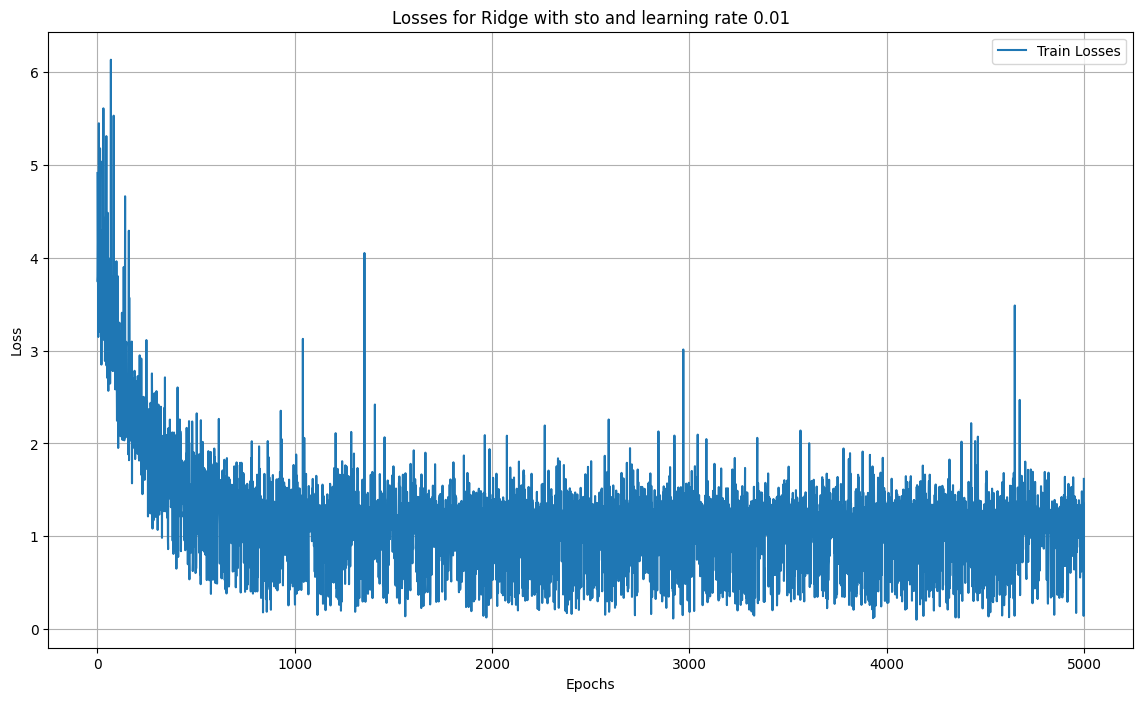

=========Classification report=======
             precision recall f1-score support
0                 0.63   0.97     0.76   411.0
1                 0.51   0.18     0.26   456.0
2                 0.47   0.51     0.49   352.0
3                 0.71   0.81     0.76   387.0
accuracy                           0.6    1606
macro avg         0.58   0.61     0.57  1606.0
weighted avg      0.58    0.6     0.56  1606.0
===== Training Ridge with sto and learning rate 0.001 =====
Loss at iteration 0 4.57257640019392
Loss at iteration 500 3.103714216535345
Loss at iteration 1000 2.8672801752237382
Loss at iteration 1500 2.8926636894235984
Loss at iteration 2000 2.812164137380544
Loss at iteration 2500 2.181389326584196
Loss at iteration 3000 1.9821548879200763
Loss at iteration 3500 1.680253624210221
Loss at iteration 4000 1.532947363208241
Loss at iteration 4500 1.1416511279458623
time taken: 0.13867497444152832


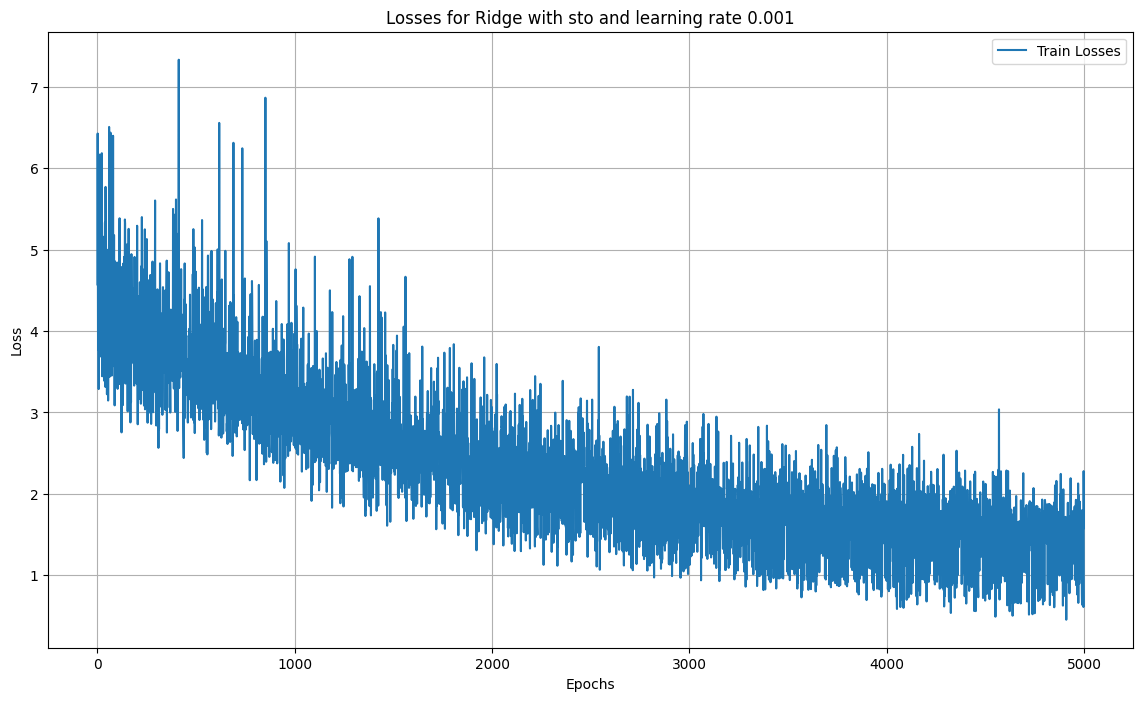

=========Classification report=======
             precision recall f1-score support
0                 0.62   0.87     0.72   411.0
1                 0.45    0.1     0.16   456.0
2                 0.39   0.59     0.47   352.0
3                 0.68   0.71      0.7   387.0
accuracy                          0.55    1606
macro avg         0.53   0.57     0.51  1606.0
weighted avg      0.53   0.55      0.5  1606.0
===== Training Ridge with sto and learning rate 0.0001 =====
Loss at iteration 0 4.452790181148096
Loss at iteration 500 4.778501464630896
Loss at iteration 1000 3.032786161981082
Loss at iteration 1500 4.1719581006363295
Loss at iteration 2000 2.662086945468933
Loss at iteration 2500 3.955910310217666
Loss at iteration 3000 3.8848840870609527
Loss at iteration 3500 4.0284208362288325
Loss at iteration 4000 4.617354282251467
Loss at iteration 4500 4.086535273853292
time taken: 0.13730692863464355


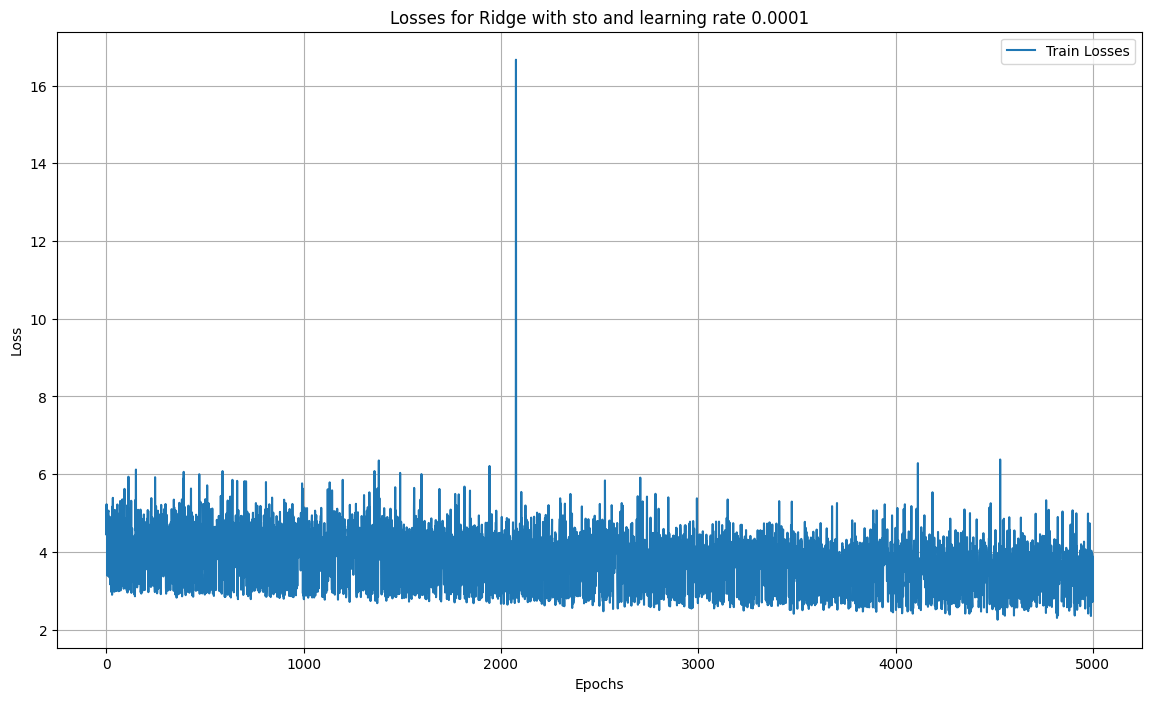

=========Classification report=======
             precision recall f1-score support
0                  0.4   0.06      0.1   411.0
1                 0.32   0.18     0.23   456.0
2                 0.04   0.02     0.03   352.0
3                 0.35   0.98     0.51   387.0
accuracy                          0.31    1606
macro avg         0.28   0.31     0.22  1606.0
weighted avg      0.28   0.31     0.22  1606.0


In [26]:
# Loop through different models, methods, and learning rates
regs = ["SimpleLogistic", "Ridge"]
methods = ["batch", "minibatch", "sto"]
alphas = [0.01, 0.001, 0.0001]

for reg in regs:
    for method in methods:
        for alpha in alphas:

                if reg == "Ridge": # Check if Ridge to add l2 parameter
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha,
                        "l2": 0.1
                    }
                else:
                    params = {
                        "k": len(set(y_train)),
                        "n": X_train_transformed.shape[1],
                        "method": method,
                        "alpha": alpha
                    }

                with mlflow.start_run(run_name=f"{reg}-method-{method}-learning_rate-{alpha}", nested=True):

                    print("=" * 5, f"Training {reg} with {method} and learning rate {alpha}", "=" * 5)
                    
                    for key, value in params.items():
                        mlflow.log_param(key, value)

                    logis_type = str_to_class(reg)
                    model = logis_type(**params)
                    # Train the model and predict
                    model.fit(X_train_transformed, y_train_one_hot)
                    yhat = model.predict(X_test_transformed)
                    # Plot the losses
                    fig, ax = plt.subplots(figsize=(14,8))
                    model.plot()
                    plt.title(f"Losses for {reg} with {method} and learning rate {alpha}")
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.grid()
                    if not os.path.exists("./figures"):
                        os.makedirs("./figures")
                    # Save figure image to figure folder
                    fig_path = f"./figures/{reg}-{method}-{alpha}.png"
                    plt.savefig(fig_path)
                    mlflow.log_artifact(fig_path, artifact_path="figures")
                    plt.show()
                    print("=========Classification report=======")
                    print(model.classification_report(y_test, yhat))
                    # Log all metrics to MLflow calculate function by function
                    acc = model.accuracy(y_test, yhat) # accuracy
                    macro_prec = model.macro_precision(y_test, yhat) # macro precision
                    macro_rec = model.macro_recall(y_test, yhat) # macro recall
                    macro_f1 = model.macro_f1_score(y_test, yhat) # macro f1
                    weighted_prec = model.weighted_precision(y_test, yhat) # weighted precision
                    weighted_rec = model.weighted_recall(y_test, yhat) # weighted recall
                    weighted_f1 = model.weighted_f1_score(y_test, yhat) # weighted f1
                    mlflow.log_metric("accuracy", acc)
                    mlflow.log_metric("macro_precision", macro_prec)
                    mlflow.log_metric("macro_recall", macro_rec)
                    mlflow.log_metric("macro_f1", macro_f1)
                    mlflow.log_metric("weighted_precision", weighted_prec)
                    mlflow.log_metric("weighted_recall", weighted_rec)
                    mlflow.log_metric("weighted_f1", weighted_f1)
                    for cls in np.unique(y_test):
                        prec = model.precision(y_test, yhat, cls) # precision for each class
                        rec = model.recall(y_test, yhat, cls) # recall for each class
                        f1 = model.f1_score(y_test, yhat, cls) # f1 for each class
                        mlflow.log_metric(f"precision_class_{cls}", prec)
                        mlflow.log_metric(f"recall_class_{cls}", rec)
                        mlflow.log_metric(f"f1_score_class_{cls}", f1)
                    # signature = mlflow.models.infer_signature(X_train_transformed, yhat)
                    # mlflow.sklearn.log_model(model, artifact_path="model", signature=signature)


In [27]:
# Find the best model 
from mlflow.tracking import MlflowClient
from mlflow.exceptions import RestException

# Create an MLflow client and get the experiment by name
client = MlflowClient()
experiment = client.get_experiment_by_name("st126235-a3")

# Pull runs in experiment then sort to find best macro_f1 (Use macro_f1 as main metric because it is balanced for all classes and not affected by class imbalance)
runs = client.search_runs(
    [experiment.experiment_id],
    order_by=["metrics.macro_f1 DESC"],
    max_results = 1
)

# Display the best run details
best_run = runs[0]
run_id = best_run.info.run_id
print("Best run ID:", run_id)
print("Best macro_f1:", best_run.data.metrics["macro_f1"])

Best run ID: 0861060aaae64dcab9bdd86b07646776
Best macro_f1: 0.7657308078233591


Best run parameters: {'l2': '0.1', 'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}
Loss at iteration 0 1.5360437028930065
Loss at iteration 500 0.5980676156733911
Loss at iteration 1000 0.5789913211267882
Loss at iteration 1500 0.571690148750641
Loss at iteration 2000 0.5827058511213028
Loss at iteration 2500 0.5847454183409282
Loss at iteration 3000 0.5787456903165045
Loss at iteration 3500 0.5717289241127931
Loss at iteration 4000 1.5403171970374667
Loss at iteration 4500 0.5959786447688337
time taken: 1.1105129718780518


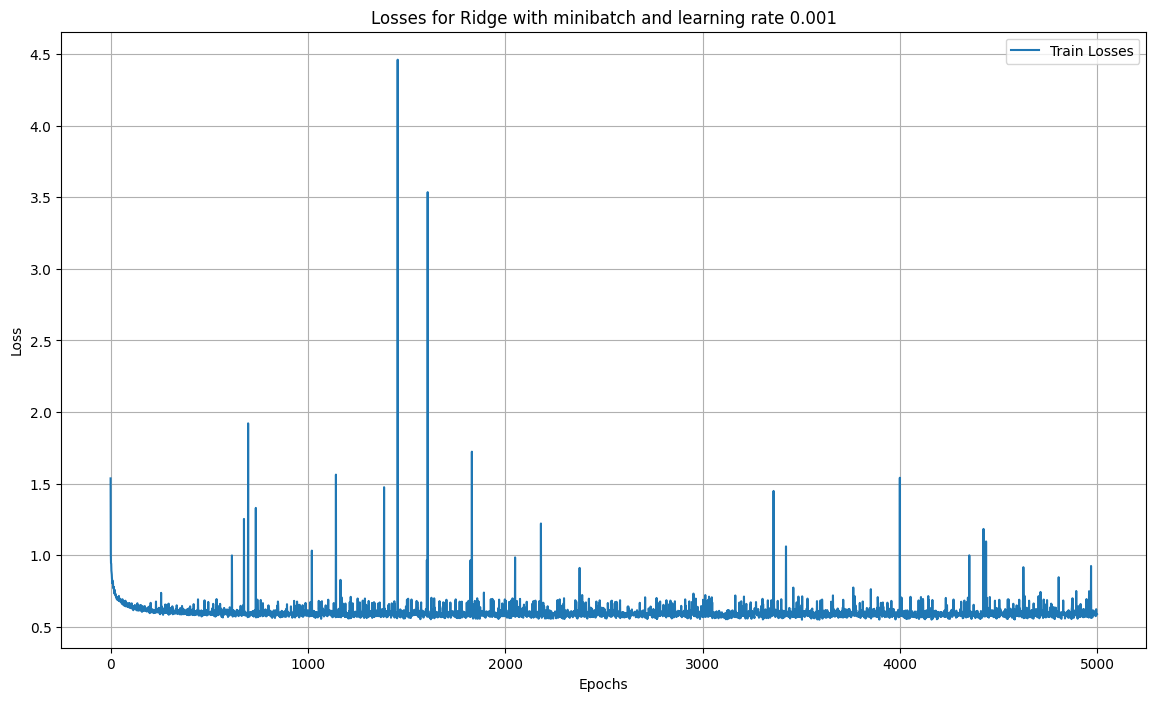

=========Classification report=======
             precision recall f1-score support
0                 0.85   0.83     0.84   411.0
1                 0.69   0.69     0.69   456.0
2                 0.63   0.67     0.65   352.0
3                 0.86   0.84     0.85   387.0
accuracy                          0.76    1606
macro avg         0.76   0.76     0.76  1606.0
weighted avg      0.76   0.76     0.76  1606.0


2025/10/05 13:07:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Current run ID: 605e86693e4846ce9a2e698269574a8c


In [28]:
# Log model to MLFlow for the best run
params = best_run.data.params
print("Best run parameters:", params)
# Create a new run to log the best model
with mlflow.start_run(run_name=f"Best_model_{run_id}") as run:
    # Check if params includes l2 for Ridge or not for SimpleLogistic
    if 'l2' in params:
        model = Ridge(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha']),
            l2=float(params['l2'])
        )
    else:
        model = SimpleLogistic(
            k=int(params['k']),
            n=int(params['n']),
            method=params['method'],
            alpha=float(params['alpha'])
        )
    mlflow.log_params(params)
    # Train the model and predict
    model.fit(X_train_transformed, y_train_one_hot)
    yhat = model.predict(X_test_transformed)
    # Plot training history
    fig, ax = plt.subplots(figsize=(14,8))
    model.plot()
    regbest = 'SimpleLogistic' if 'l2' not in params else 'Ridge'
    methodbest = params['method']
    alphabest = params['alpha']
    plt.title(f"Losses for {regbest} with {methodbest} and learning rate {alphabest}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    # Save figure image to figure folder
    fig_path = f"./figures/best-{regbest}-{methodbest}-{alphabest}.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path, artifact_path="figures")
    plt.show()
    print("=========Classification report=======")
    print(model.classification_report(y_test, yhat))
    # Log all metrics to MLflow calculate function by function
    acc = model.accuracy(y_test, yhat) # accuracy
    macro_prec = model.macro_precision(y_test, yhat) # macro precision
    macro_rec = model.macro_recall(y_test, yhat) # macro recall
    macro_f1 = model.macro_f1_score(y_test, yhat) # macro f1
    weighted_prec = model.weighted_precision(y_test, yhat) # weighted precision
    weighted_rec = model.weighted_recall(y_test, yhat) # weighted recall
    weighted_f1 = model.weighted_f1_score(y_test, yhat) # weighted f1
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("macro_precision", macro_prec)
    mlflow.log_metric("macro_recall", macro_rec)
    mlflow.log_metric("macro_f1", macro_f1)
    mlflow.log_metric("weighted_precision", weighted_prec)
    mlflow.log_metric("weighted_recall", weighted_rec)
    mlflow.log_metric("weighted_f1", weighted_f1)
    for cls in np.unique(y_test):
        prec = model.precision(y_test, yhat, cls) # precision for each class
        rec = model.recall(y_test, yhat, cls) # recall for each class
        f1 = model.f1_score(y_test, yhat, cls) # f1 for each class
        mlflow.log_metric(f"precision_class_{cls}", prec)
        mlflow.log_metric(f"recall_class_{cls}", rec)
        mlflow.log_metric(f"f1_class_{cls}", f1)
    signature = mlflow.models.infer_signature(X_train_transformed, yhat) # infer model signature
    mlflow.sklearn.log_model(model, artifact_path="model", signature=signature) # log the model

    current_run_id = run.info.run_id # Get the current run ID
    print("Current run ID:", current_run_id)

In [29]:
# Register model
model_uri = f"runs:/{current_run_id}/model" # Use the current run ID to get the model URI
model_name = "st126235-a3-model" # Define the model name
try:
    result = mlflow.register_model(model_uri, model_name) # Register the model
    print(f"Model registered: {result.name}, version: {result.version}")
    model_version = result.version # Get the model version
    # Add time sleep
    time.sleep(2)  # Wait for a few seconds to ensure the model is registered
except RestException as e:
    print(f"Model registration failed: {e}")

Registered model 'st126235-a3-model' already exists. Creating a new version of this model...
2025/10/05 13:07:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126235-a3-model, version 11
Created version '11' of model 'st126235-a3-model'.


Model registered: st126235-a3-model, version: 11


In [30]:
# Check registered model in mlflow
for rm in mlflow.search_registered_models():
    if rm.name == model_name:
        print(f"Model name: {rm.name}")
        for mv in rm.latest_versions:
            print(f"  Version: {mv.version}, Stage: {mv.current_stage}, Status: {mv.status}")

Model name: st126235-a3-model
  Version: 9, Stage: Archived, Status: READY
  Version: 11, Stage: None, Status: READY
  Version: 10, Stage: Production, Status: READY


In [31]:
print(mlflow.__version__) # Check MLflow version

2.8.1


In [32]:
# Check if model version exists and is ready

try:
    model_version_details = client.get_model_version(name=model_name, version=model_version) # Get model version details
    print(f"Model version status: {model_version_details.status}")
    
    if model_version_details.status == "READY":
        # Add alias to the model version
        alias_name = "Staging"
        try:
            # Ensure the version is passed as a string to set_registered_model_alias
            client.set_registered_model_alias(name=model_name, alias=alias_name, version=str(model_version))
            print(f"Alias '{alias_name}' set for model version {model_version}")
        except Exception as e:
            print(f"Failed to set alias: {e}")
        # Transition the model to staging
        client.transition_model_version_stage(
            name=model_name, 
            version=int(model_version), 
            stage="Staging",
            archive_existing_versions=True
        )
        print(f"Model version {model_version} transitioned to Staging")
    else:
        print(f"Model version not ready. Current status: {model_version_details.status}")
        
except Exception as e:
    print(f"Error during transition: {e}")

Model version status: READY
Alias 'Staging' set for model version 11
Model version 11 transitioned to Staging


In [33]:
# Load staging model
loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}/staging")

In [34]:
# Inference with the model
synthetic_data = {
    'year': [2014, 2015],
    'km_driven': [50000, 30000],
    'fuel': ['Diesel', 'Petrol'],
    'transmission': ['Manual', 'Automatic'],
    'owner': [1, 1],
    'engine': [1500, 1200],
    'max_power': [100, 80],
    'brand': ['Maruti', 'Hyundai'],
    'mileage': [18.0, 20.0]
}
# Create a DataFrame for synthetic data
X_synthetic = pd.DataFrame(synthetic_data)
# Preprocess the synthetic data
X_synthetic_transformed = prep.transform(X_synthetic)
# Predict the class using the loaded model
predictions = loaded_model.predict(X_synthetic_transformed)
# Display the predictions
print("Details of synthetic data samples:\n", X_synthetic)
print("The first synthetic data sample predicted class:", predictions[0])
print("The second synthetic data sample predicted class:", predictions[1])


Details of synthetic data samples:
    year  km_driven    fuel transmission  owner  engine  max_power    brand  \
0  2014      50000  Diesel       Manual      1    1500        100   Maruti   
1  2015      30000  Petrol    Automatic      1    1200         80  Hyundai   

   mileage  
0     18.0  
1     20.0  
The first synthetic data sample predicted class: 3
The second synthetic data sample predicted class: 1


In [35]:
# Conclude the best model parameters
print("Best model parameters:", params)

Best model parameters: {'l2': '0.1', 'method': 'minibatch', 'alpha': '0.001', 'n': '38', 'k': '4'}


## Experiment Report - Predicting Car Price (Classification)

**Student ID**: st126235

Github Link: https://github.com/dniamsaard4codework/A3-Predicting-Car-Price.git

![Github](images/githubb.png)

Link to the website: https://st126235.ml.brain.cs.ait.ac.th/

![Website](images/web.png)

---

### Introduction

The goal of this experiment is to predict car prices by turning a regression problem into a classification task. The preprocessor from assignment 2 is reused in this assignment. This experiment compares Multinomial Logistic Regression with and without Ridge regularization, and logs the model for deployment with MLFlow. Moreover, I set up CI/CD in GitHub Actions.

---

### Task

- Convert the `selling_price` variable into 4 classes (0–3) based on quantiles.  
- Build a Logistic Regression model from scratch.  
- Implement evaluation metrics (Accuracy, Precision, Recall, F1, Macro, Weighted) manually.  
- Extend the model with Ridge (L2) regularization.  
- Log and compare different experiments using MLflow.  
- Prepare for deployment with CI/CD via GitHub Actions.

---

### Preparation

- Load `Cars.csv` dataset
- Using previous assignment (A2) preprocessor to scale numeric columns and one-hot encode categorical features.  
- Using pd.cut to make `selling_price` to be categorical `price_class` with quartile separation and then one-hot encoded for training.

---

### Modeling

I created a custom Logistic Regression class supporting:
- Batch, mini-batch, and stochastic gradient descent.  
- Softmax function for multi-class classification.  
- Manual gradient calculation.  
- Evaluation metrics: accuracy, precision, recall, F1, macro, weighted.
- For Ridge Logistic Regression, I added L2 penalty to the loss and gradient functions.

Ridge Equation (From assignment pdf):
$$J(\theta) = -\sum_{i=1}^m y^{(i)}\log(h^{(i)}) + \lambda\sum_{j=1}^n \theta_j^{2}$$
This allows controlling overfitting by penalizing large weights.


Moreover, I have created the manual classification report 


**Precision (Class \(c\))**  
$$\text{Precision}_c=\frac{\mathrm{TP}_c}{\mathrm{TP}_c+\mathrm{FP}_c}$$
How many predicted as class \(c\) are actually class \(c\).

**Recall (Class \(c\))**  
$$\text{Recall}_c=\frac{\mathrm{TP}_c}{\mathrm{TP}_c+\mathrm{FN}_c}$$
How many of the true class \(c\) we correctly found.

**F1-Score (Class \(c\))**  
$$\text{F1}_c=\frac{2\cdot \text{Precision}_c\cdot \text{Recall}_c}{\text{Precision}_c+\text{Recall}_c}$$
Balance between precision and recall for class \(c\).

**Support (Class \(c\))**  
$$\text{Support}_c=\#\{\text{true samples of class }c\}$$
Number of true samples in class \(c\).

**Accuracy (Overall)**  
$$\text{Accuracy}=\frac{\text{\# correct predictions}}{\text{\# all predictions}}=\frac{\sum_c \mathrm{TP}_c}{\sum_c(\mathrm{TP}_c+\mathrm{FP}_c)}$$
Share of predictions that are correct across all classes.

**Macro Precision / Recall / F1**  
$$\text{Macro-Precision}=\frac{1}{|C|}\sum_{c\in C}\text{Precision}_c$$
$$\text{Macro-Recall}=\frac{1}{|C|}\sum_{c\in C}\text{Recall}_c$$
$$\text{Macro-F1}=\frac{1}{|C|}\sum_{c\in C}\text{F1}_c$$
Simple average across classes (treats all classes equally).

**Weighted Precision / Recall / F1**  
Let  
$$N=\sum_{c\in C}\text{Support}_c$$
$$\text{Weighted-Precision}=\sum_{c\in C}\frac{\text{Support}_c}{N}\,\text{Precision}_c$$
$$\text{Weighted-Recall}=\sum_{c\in C}\frac{\text{Support}_c}{N}\,\text{Recall}_c$$
$$\text{Weighted-F1}=\sum_{c\in C}\frac{\text{Support}_c}{N}\,\text{F1}_c$$
Average across classes, weighted by class sizes.

---

### MLFlow Experiment setup

I configured MLFlow to log experiments to the CSIM MLflow server

Steps:

1. Set the `tracking_uri` to the MLflow server URL.  
2. Set the experiment name as `st126235-a3`.  
3. Log parameters such as learning rate, regularization type, and method.  
4. Log metrics including accuracy, macro/weighted precision, recall, and F1 score.  
5. Log artifacts such as loss curve plots.

After training, I registered the best model in MLflow Model Registry under the name `st126235-a3-model` and set its stage to Staging.

---

### Result
The log of each model can see in the https://mlflow.ml.brain.cs.ait.ac.th/#/experiments/607305997044080535

![MLFlow](images/126235-mlflow.png)

The best model is Ridge with minibatch and learning rate at 0.001

#### Classification Report


<div align="center">

| Class | Precision | Recall | F1-score | Support |
|:-----:|:---------:|:------:|:--------:|:-------:|
| **0** | 0.85 | 0.83 | 0.84 | 411 |
| **1** | 0.69 | 0.69 | 0.69 | 456 |
| **2** | 0.63 | 0.67 | 0.65 | 352 |
| **3** | 0.86 | 0.84 | 0.85 | 387 |
| **Accuracy** |   |   | **0.76** | 1606 |
| **Macro Avg** | 0.76 | 0.76 | 0.76 | 1606 |
| **Weighted Avg** | 0.76 | 0.76 | 0.76 | 1606 |

</div>

Below shows the loss graph of the best model.

![Best Model](figures/best-Ridge-minibatch-0.001.png)

---

### CI/CD

- CI: GitHub Actions run build-test.yml (build, tests, optional deploy) and test-model-staging.yml (model checks). Tests cover app callbacks, model load/predict, and run inside Docker.
- Testing: Triggers on every push/PR.
  - Unit tests: verify the model accepts the expected input shape and returns the expected output shape (in test_model_staging.py).
  - App tests: validate Dash callback behavior (in test_app_callbacks.py).
  - Gate to deploy: deployment only proceeds if all tests pass.
- CD: Three stages include dev (local), staging (auto), prod (Traefik). Tag v* triggers builds, pushes to Docker Hub, deploys via SSH with zero downtime.
- MLOps: MLflow tracks runs and versions. Best model registered as st126235-a3-model. transition.py promotes from Staging to Production after tests.
  - Infra & Security: Multi-stage Docker, non-root user, health checks, secrets in GitHub, SSL via Traefik, isolated networks.

![staging](images/stagingtest.png)
![build](images/buildtest.png)

---

### Conclusion and Discussion

This work turned car price prediction into a four-class problem and delivered solid results. The Ridge Logistic Regression model with mini-batch training and learning rate 0.001 reached 76% accuracy. Precision, recall, and F1 were close across classes, which shows stable behavior. Class 2 performed slightly lower, which likely came from class imbalance in the data. Regularization limited overfitting by shrinking large weights, and mini-batch updates gave smoother learning than pure stochastic updates.

Writing the metrics and the classification report by hand improved understanding of model errors. It also made it easy to compare with the scikit-learn report and confirm that the implementation was correct. MLflow helped track runs, parameters, and plots in one place, which supported fair comparisons and quick selection of the best model. The CI/CD pipeline ran tests on each commit, verified model I/O shapes, and deployed only after all checks passed. This kept the code and the model reliable, and it made the whole workflow reproducible and easier to maintain.